In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pywt
import math
import scipy.stats as st
import pandas as pd
from matplotlib.colors import LogNorm

In [18]:
def dynamic_spectrum(signal, fps, plot=False):
    """
    Computes the dynamic spectrum (time-frequency array) of a 1D signal using the Complex Morlet Wavelet.
    Args:
    - signal (numpy.ndarray): 1D array representing the signal over time.
    - fps (float): Frames per second of the signal =
    - plot (bool, optional): If True, plots the dynamic spectrum. Default is False.
    Returns:
    - power_norm (numpy.ndarray): Normalized power of the wavelet transform.
    - frequencies (numpy.ndarray): Corresponding frequency values.
    """

    wavelet = 'cmor2.0-1.0'  # Complex Morlet wavelet

    # Define Frequency-Optimized Scales
    desired_freqs = np.linspace(1, 40, 100)
    scales = pywt.central_frequency(wavelet) * fps / desired_freqs

    # Compute Wavelet Transform
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, 1 / fps)
    power = np.abs(coefficients) ** 2  # Compute power spectrum

    # Keep Only Frequencies Below 30 Hz
    valid_idx = (frequencies >= 1.5) & (frequencies <= 40)
    frequencies = frequencies[valid_idx]
    scales = scales[valid_idx]
    power = power[valid_idx, :]  # Keep only low-frequency data
    power = power / scales[:, np.newaxis]
    
    return power, frequencies


In [50]:
def plot_mouse_mean_spectra(mouse_name, all_results, logscale=False, common_color_scale=True):
    trial_type_names = ['HC Hit', 'HC Miss', 
                        'MC Hit', 'MC Miss', 'MC No Report',
                        'False Alarm', 'Correct Rejection', 'LC No Report']

    fig, axs = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    axs = axs.flatten()

    vmin, vmax = None, None
    if common_color_scale and logscale:
        # Work in log space for percentile scaling
        logvals = []
        for tt in trial_type_names:
            data = all_results[mouse_name][tt]["MeanDynamicSpectrum"] * 100
            data = data[np.isfinite(data) & (data > 0)]  # exclude zeros/NaNs
            logvals.append(np.log10(data))
        all_logvals = np.concatenate(logvals)
        log_min = np.percentile(all_logvals, 2)
        log_max = np.percentile(all_logvals, 98)

        # Ensure minimum dynamic range
        # min_log_range_ratio=100
        # if log_max - log_min < np.log10(min_log_range_ratio):
        #     log_min = log_max - np.log10(min_log_range_ratio)

        vmin = 10**log_min
        vmax = 10**log_max

    elif common_color_scale and not logscale:
        # Linear scale percentiles
        all_vals = np.concatenate([
            all_results[mouse_name][tt]["MeanDynamicSpectrum"].flatten() * 100
            for tt in trial_type_names
        ])
        vmin = np.nanpercentile(all_vals, 2)
        vmax = np.nanpercentile(all_vals, 98)

    for i, trial_type in enumerate(trial_type_names):
        result = all_results[mouse_name][trial_type]
        ax = axs[i]

        power = result["MeanDynamicSpectrum"]
        freqs = result["Frequencies"]
        time_arr = result["Time"]
        n_valid = len(result["ValidTrialIDs"])

        T, F = np.meshgrid(time_arr, freqs)
        data = power * 100

        if logscale:
            # Avoid zero or negative values in log plot
            data[data <= 0] = np.nan
            norm = LogNorm(vmin=vmin, vmax=vmax)
            im = ax.pcolormesh(T, F, data, shading='auto', cmap='jet', norm=norm)
        else:
            im = ax.pcolormesh(T, F, data, shading='auto', cmap='jet', vmin=vmin, vmax=vmax)

        ax.set_title(f'{trial_type} ({n_valid} trials)')
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Power (% change)", fontsize=8)
        cbar.ax.tick_params(labelsize=8)
    scale_type = 'Log Scaled' if logscale else 'Linear Scale'
    plt.suptitle(f"Mean Dynamic Spectra for {mouse_name} ({scale_type})", fontsize=16)
    plt.show()

In [7]:
def plot_spectra_grid(power_list, freqs, time_arr, trial_ids, title, outliers=None):
    cols = 4
    rows = math.ceil(len(trial_ids) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(16, 3 * rows), constrained_layout=True)
    axs = axs.flatten()

    for i, (tid, power) in enumerate(zip(trial_ids, power_list)):
        T, F = np.meshgrid(time_arr, freqs)
        im = axs[i].pcolormesh(T, F, power * 100, shading='auto', cmap='jet')
        axs[i].set_title(f"{tid[17:]}" + (" (Outlier)" if outliers and tid in outliers else ""))
        axs[i].set_xlabel("Time (s)")
        axs[i].set_ylabel("Freq (Hz)")
        cbar = fig.colorbar(im, ax=axs[i])
        cbar.set_label("Power (% change)", fontsize=8)
        cbar.ax.tick_params(labelsize=8)

    for ax in axs[len(trial_ids):]:
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

In [8]:
def process_trial_type(mouse_name, trial_type, outlier_std=2.5, plot=False, plot_all=False):
    with h5py.File(f"/Volumes/T7 Shield2/BehaviorDataBackup/KatiesResults/results/{mouse_name}_dynamic_spec.h5", 'r') as h5f:
        group = h5f[trial_type]
        all_signals = group["TimeSignals"][:]
        trial_ids = [tid.decode() for tid in group.attrs["TrialIDs"]]
        expected_duration = 1.5

        # Estimate fps using first valid signal
        for sig in all_signals:
            if len(sig) >= expected_duration * 10:
                fps = len(sig) / expected_duration
                break
        expected_length = int(expected_duration * fps)

        # Pad short signals with NaN
        for i, signal in enumerate(all_signals):
            if len(signal) < expected_length:
                padded = np.full(expected_length, np.nan)
                padded[:len(signal)] = signal
                all_signals[i] = padded

        # Compute dynamic spectra
        all_power, total_powers = [], []
        for sig in all_signals:
            power, freqs = dynamic_spectrum(sig, fps, plot=False)
            all_power.append(power)
            total_powers.append(np.nansum(power))  # use nansum in case power has NaNs

        all_power = np.stack(all_power)
        total_powers = np.array(total_powers)
        time_arr = np.linspace(-0.5, 1.0, all_power.shape[2])

        # Initial mean and outlier detection
        mean_power_initial = np.nanmean(all_power, axis=0)

        med = np.median(total_powers)
        mad = st.median_abs_deviation(total_powers)
        mad_zscores = np.abs((total_powers - med) / (mad * 1.4826))
        outliers = [tid for tid, z in zip(trial_ids, mad_zscores) if z > outlier_std]

        # Influence testing
        final_outliers = []
        threshold = 0.1
        for i, tid in enumerate(trial_ids):
            if tid not in outliers:
                continue
            mask = np.arange(len(trial_ids)) != i
            mean_wo_trial = np.nanmean(all_power[mask], axis=0)
            rmse = np.sqrt(np.nanmean((mean_power_initial - mean_wo_trial) ** 2))
            rel_rmse = rmse / np.nanmean(mean_power_initial)
            if rel_rmse > threshold:
                final_outliers.append(tid)

        # Recompute clean mean
        non_outlier_indices = [i for i, tid in enumerate(trial_ids) if tid not in final_outliers]
        all_power_clean = all_power[non_outlier_indices]
        mean_power_clean = np.nanmean(all_power_clean, axis=0)

        if plot:
            T, F = np.meshgrid(time_arr, freqs)
            fig, axs = plt.subplots(1, 2, figsize=(12, 4))
            for ax, mp, label in zip(axs, [mean_power_initial, mean_power_clean], ["Initial", "Cleaned"]):
                im = ax.pcolormesh(T, F, mp * 100, shading='auto', cmap='jet')
                fig.colorbar(im, ax=ax, label="Change of wavelet magnitude (%)")
                ax.set_xlabel("Time relative to stimulus (s)")
                ax.set_ylabel("Frequency (Hz)")
                ax.set_title(f"{label} Mean Dynamic Spectrum")
            fig.suptitle(f"Mean Dynamic Spectra for {mouse_name}: {trial_type}")
            plt.show()

            # Plot outlier spectra
            if final_outliers:
                outlier_indices = [i for i, tid in enumerate(trial_ids) if tid in final_outliers]
                plot_spectra_grid([all_power[i] for i in outlier_indices], freqs, time_arr,
                                  [trial_ids[i] for i in outlier_indices],
                                  title=f"Outlier Dynamic Spectra for {trial_type}", outliers=final_outliers)

            if plot_all:
                non_outlier_ids = [trial_ids[i] for i in non_outlier_indices]
                plot_spectra_grid([all_power[i] for i in non_outlier_indices], freqs, time_arr,
                                  non_outlier_ids, title=f"Non-Outlier Dynamic Spectra for {trial_type}", outliers=[])

        return {
            "ValidTrialIDs": trial_ids,
            "OutlierTrialIDs": final_outliers,
            "MeanDynamicSpectrum": mean_power_clean,
            "Frequencies": freqs,
            "Time": time_arr
        }

In [ ]:
results = process_trial_type('rfm003', 'MC Miss', outlier_std=2.5, plot=True, plot_all=True)

In [15]:
trial_type_names = ['HC Hit', 'HC Miss', 
                    'MC Hit', 'MC Miss', 'MC No Report',
                    'False Alarm', 'Correct Rejection', 'LC No Report']
mouse_names = ['cfm001', 'cfm002', 'cfm003', 'cmm001', 'cmm002', 'cmm003', 'rfm001', 'rfm002', 'rfm003']

all_results = {}

for mouse_name in mouse_names:
    all_results[mouse_name] = {} 
    for trial_type in trial_type_names:
        results = process_trial_type(mouse_name, trial_type, outlier_std=2.5, plot=False)
        all_results[mouse_name][trial_type] = results

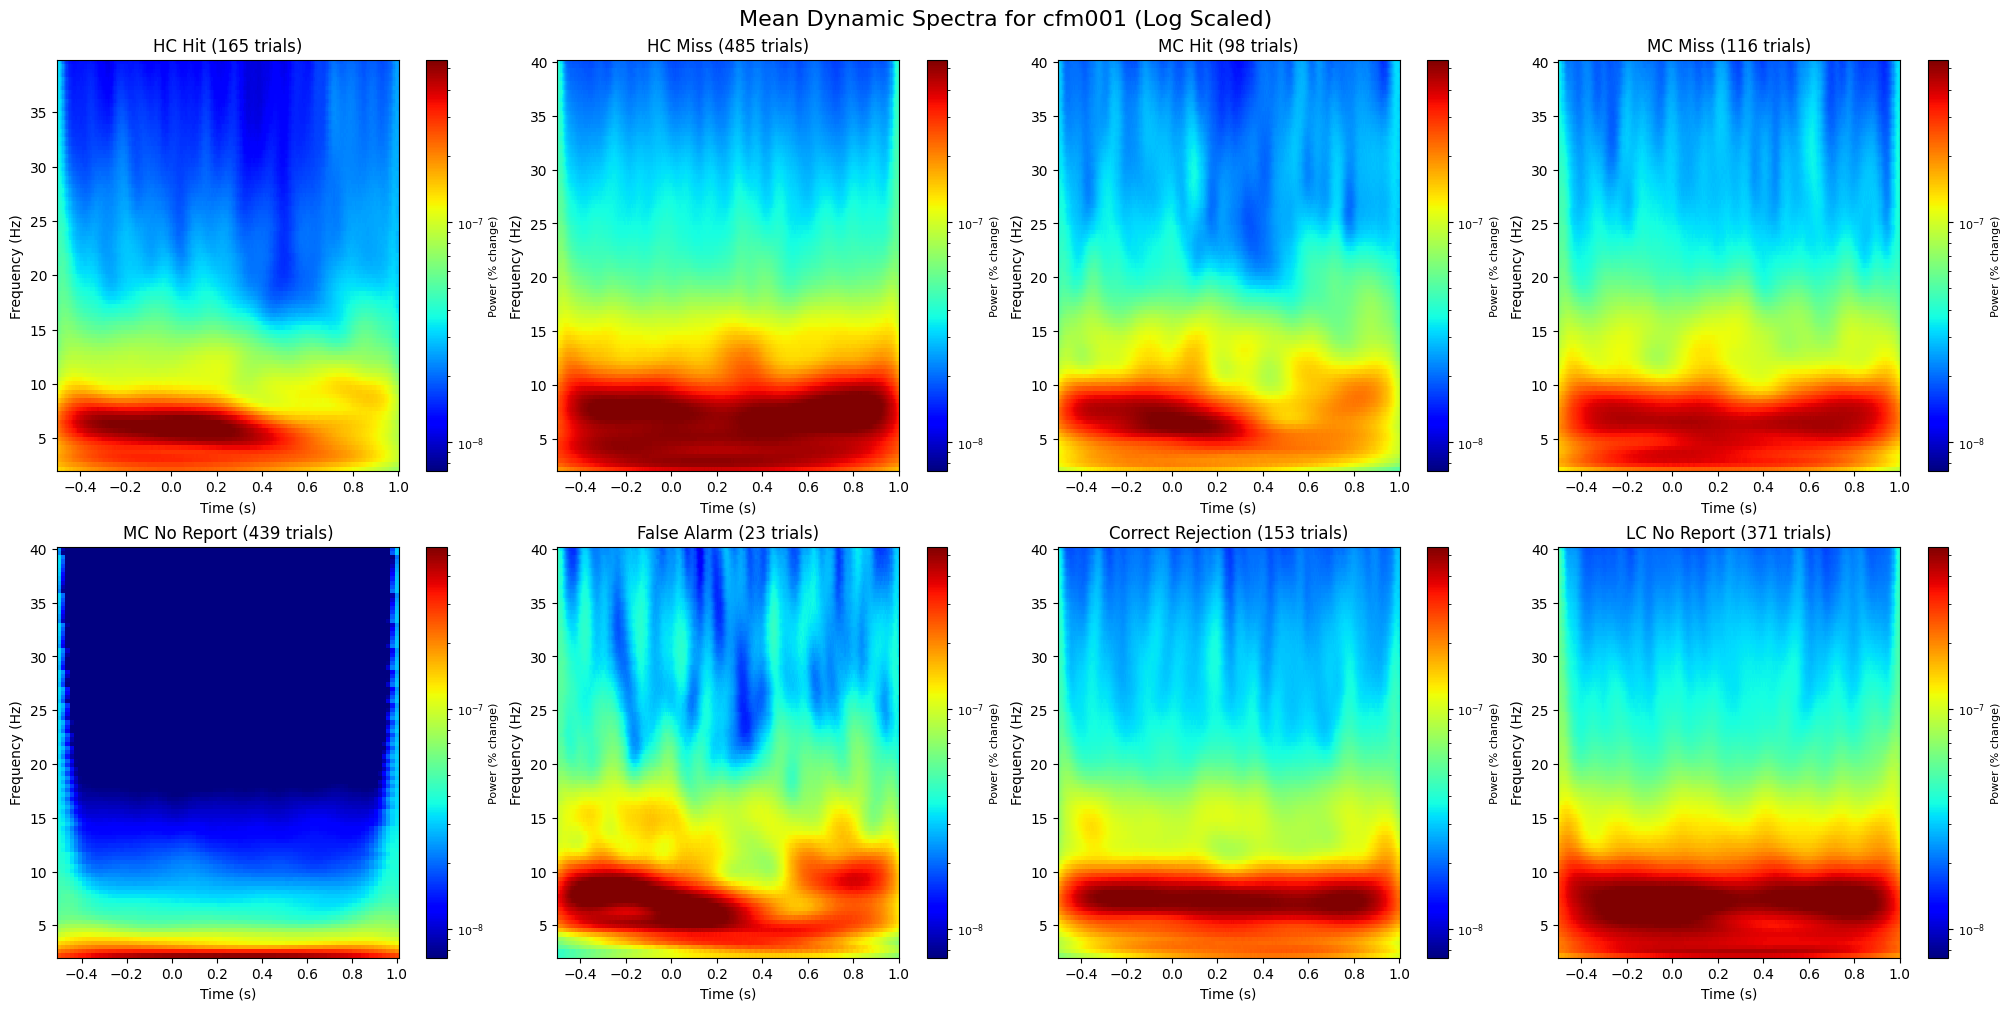

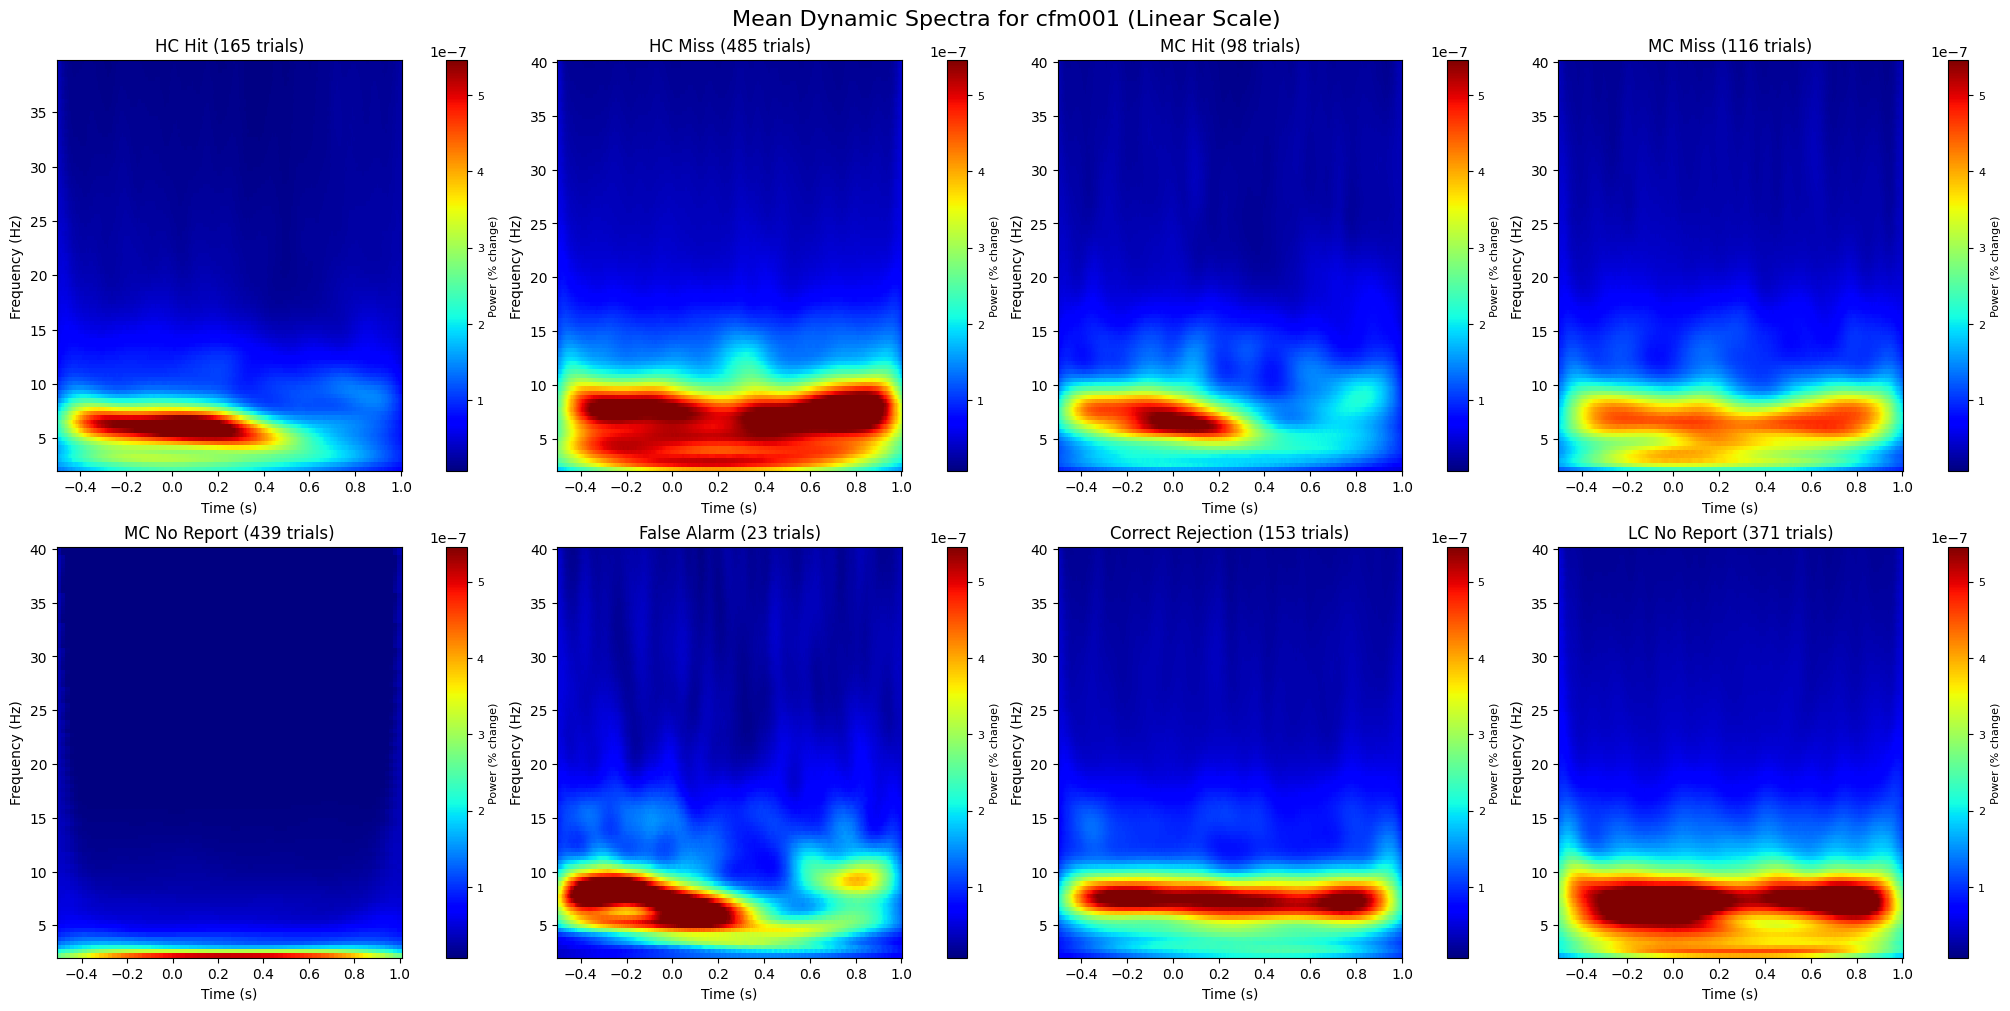

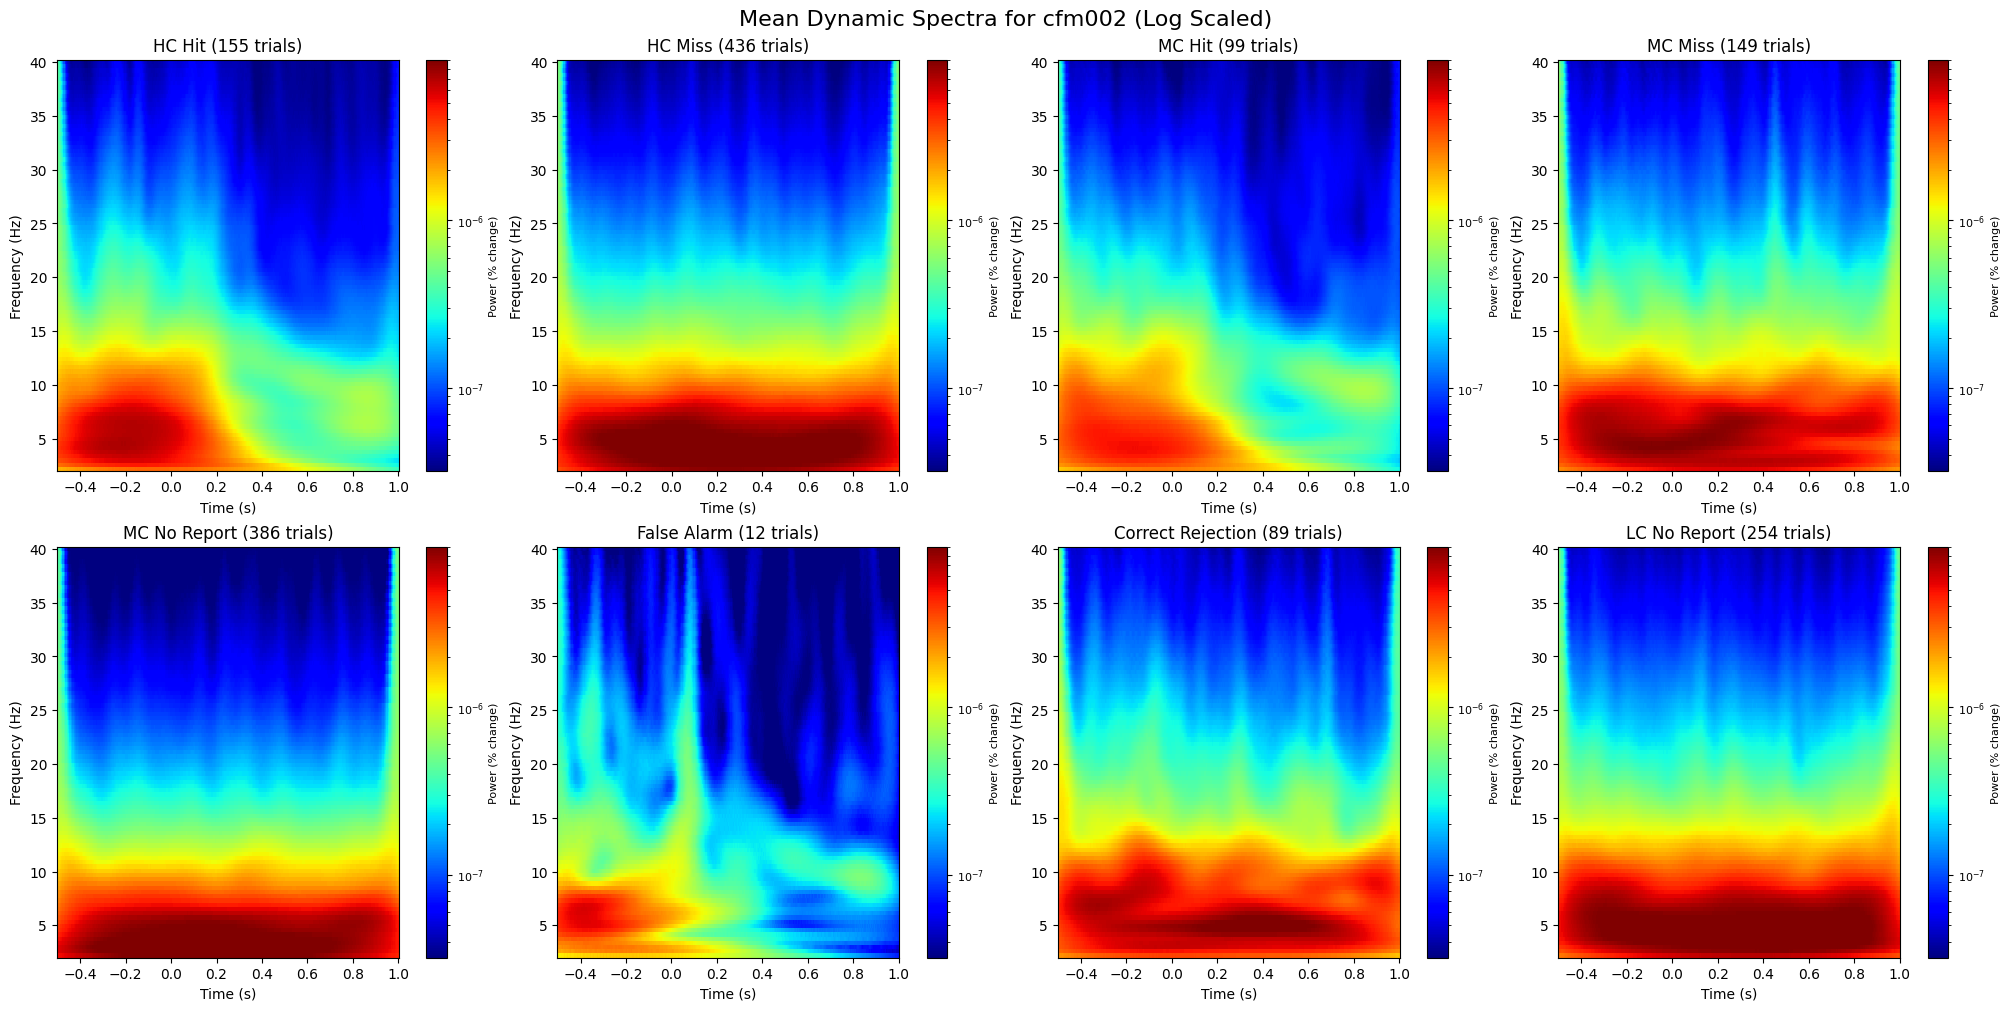

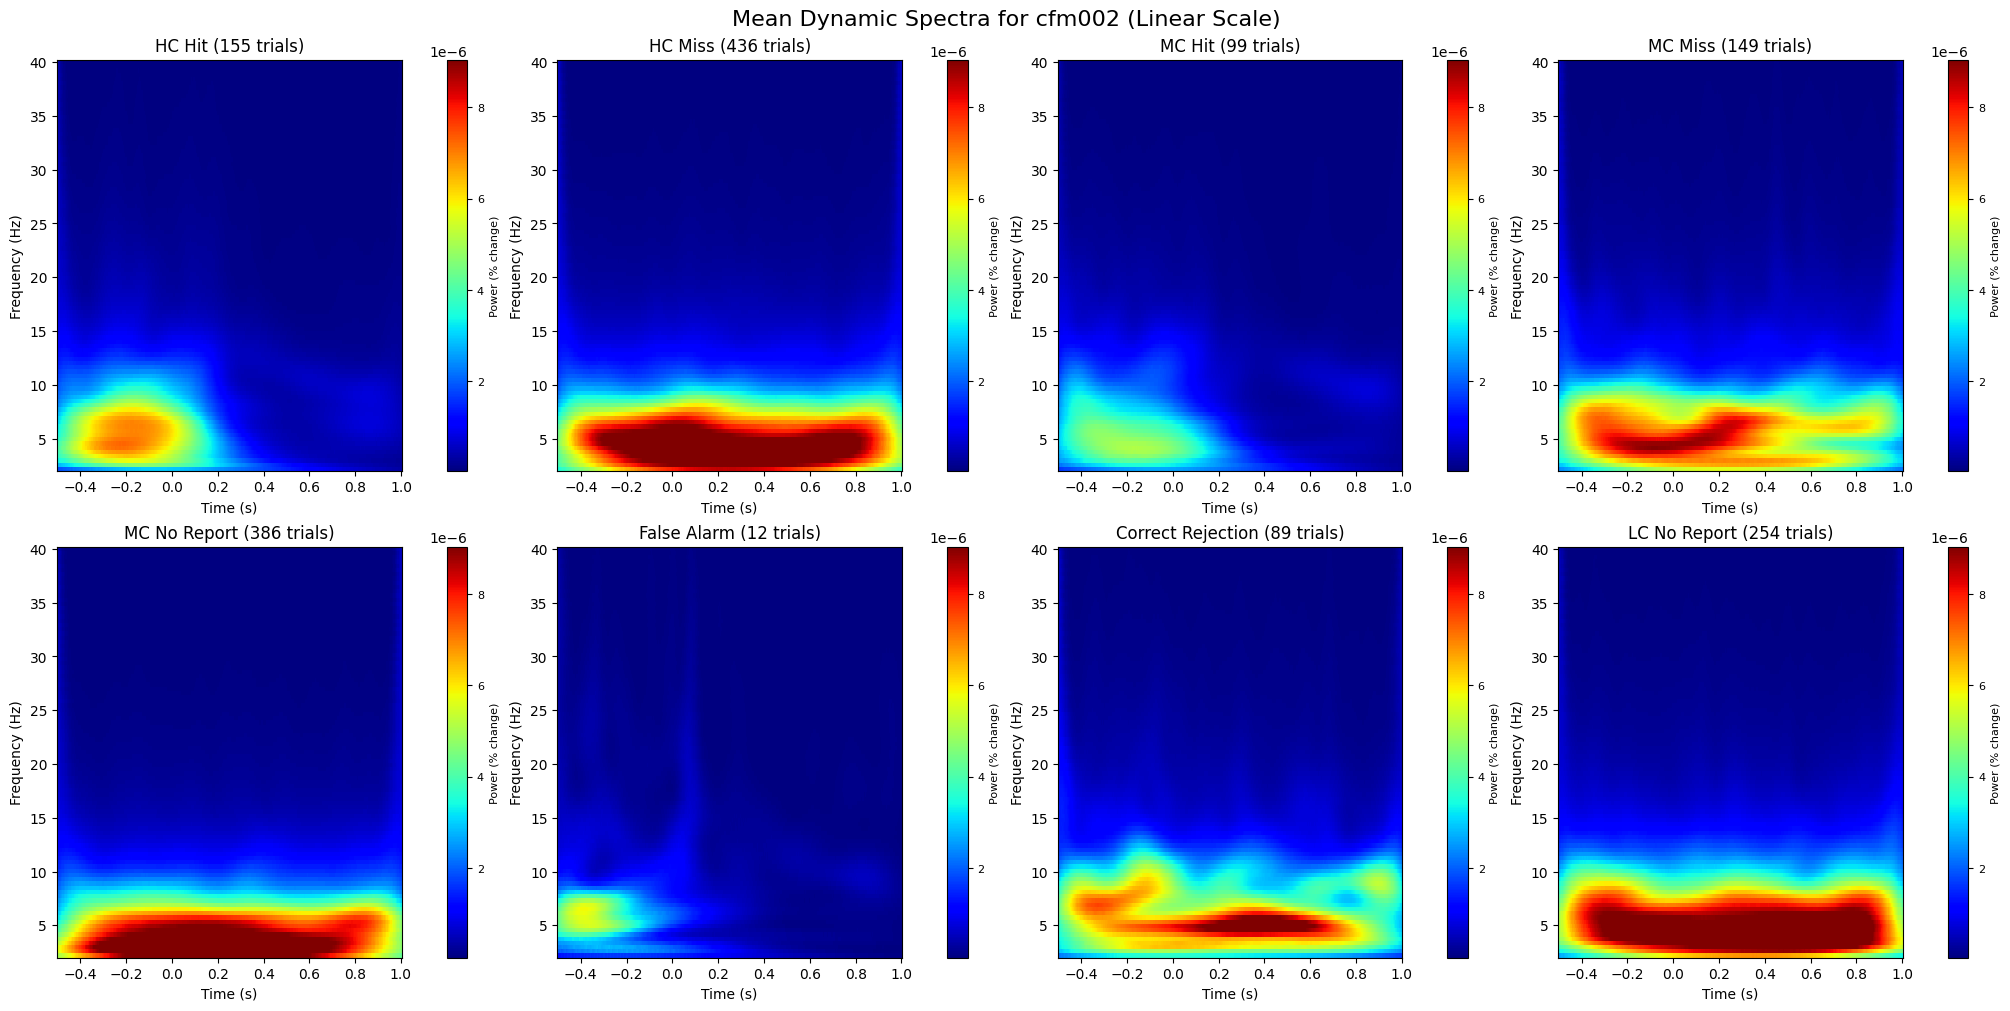

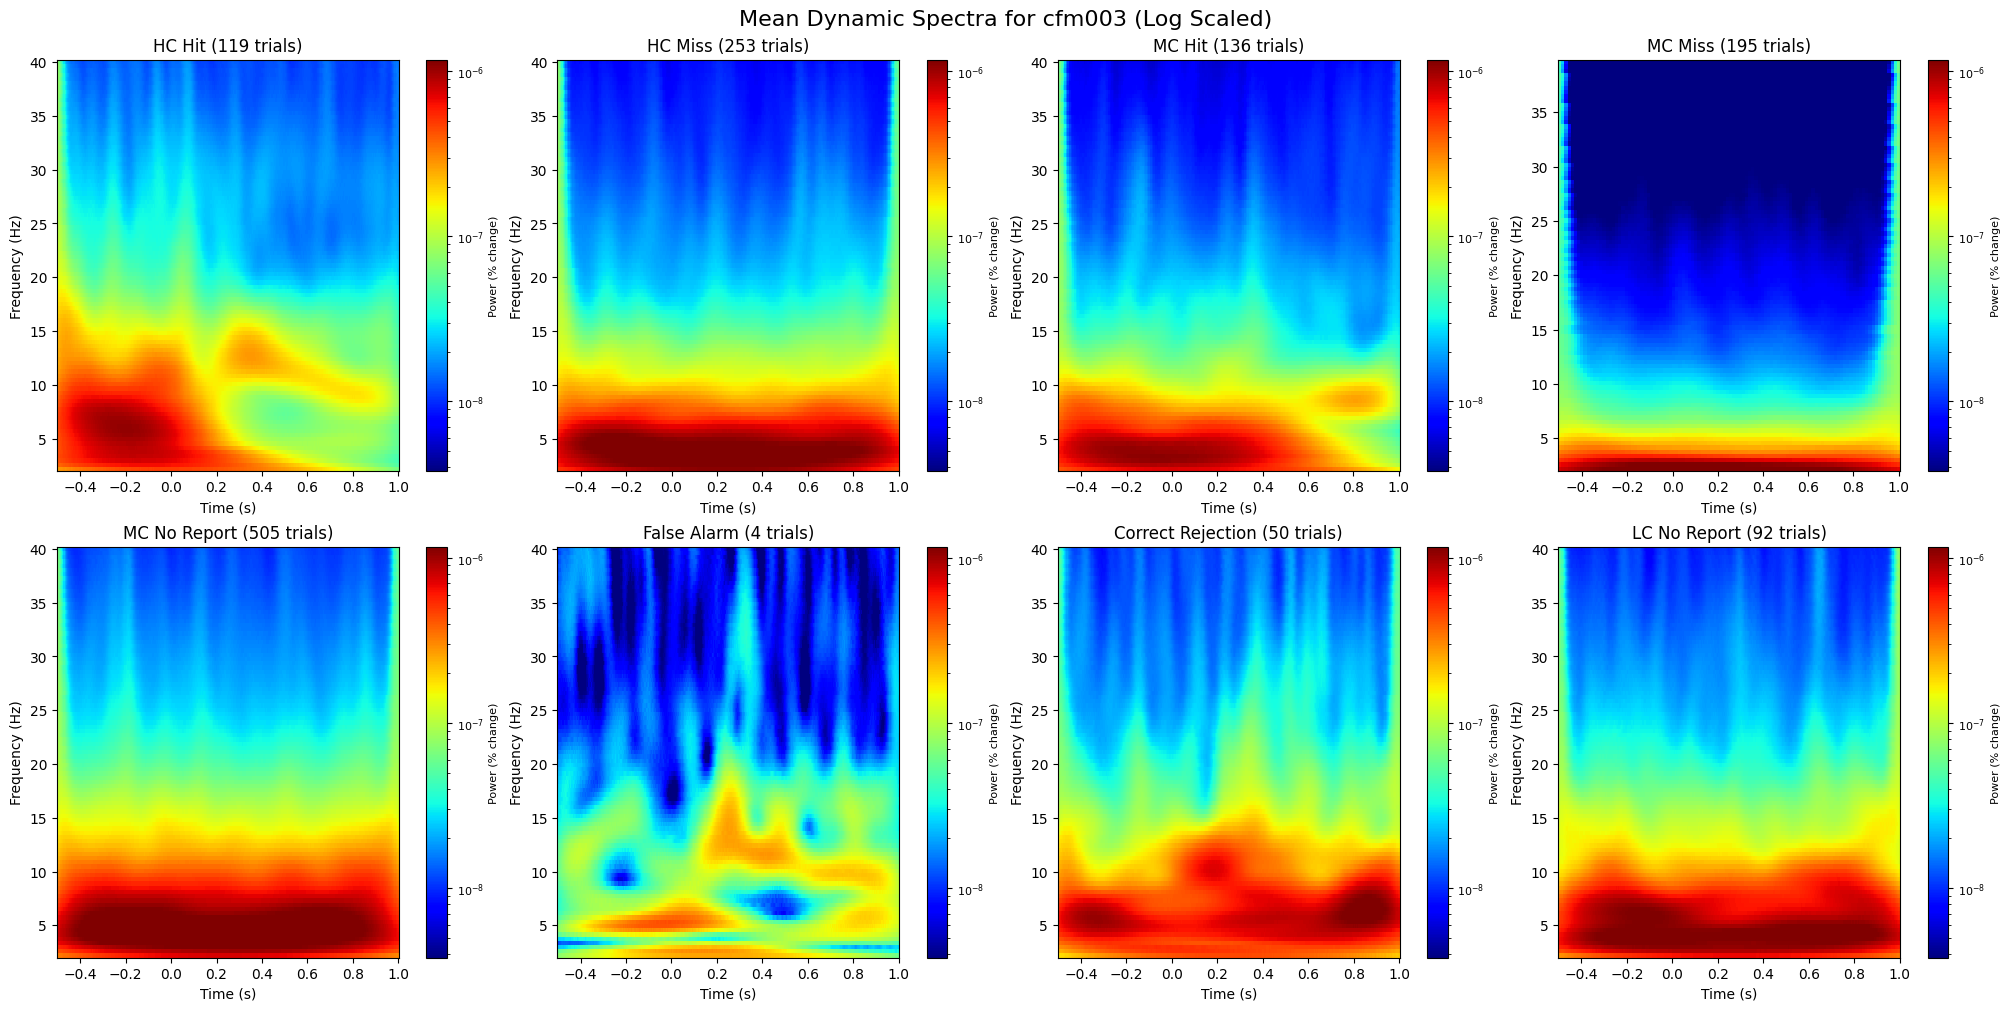

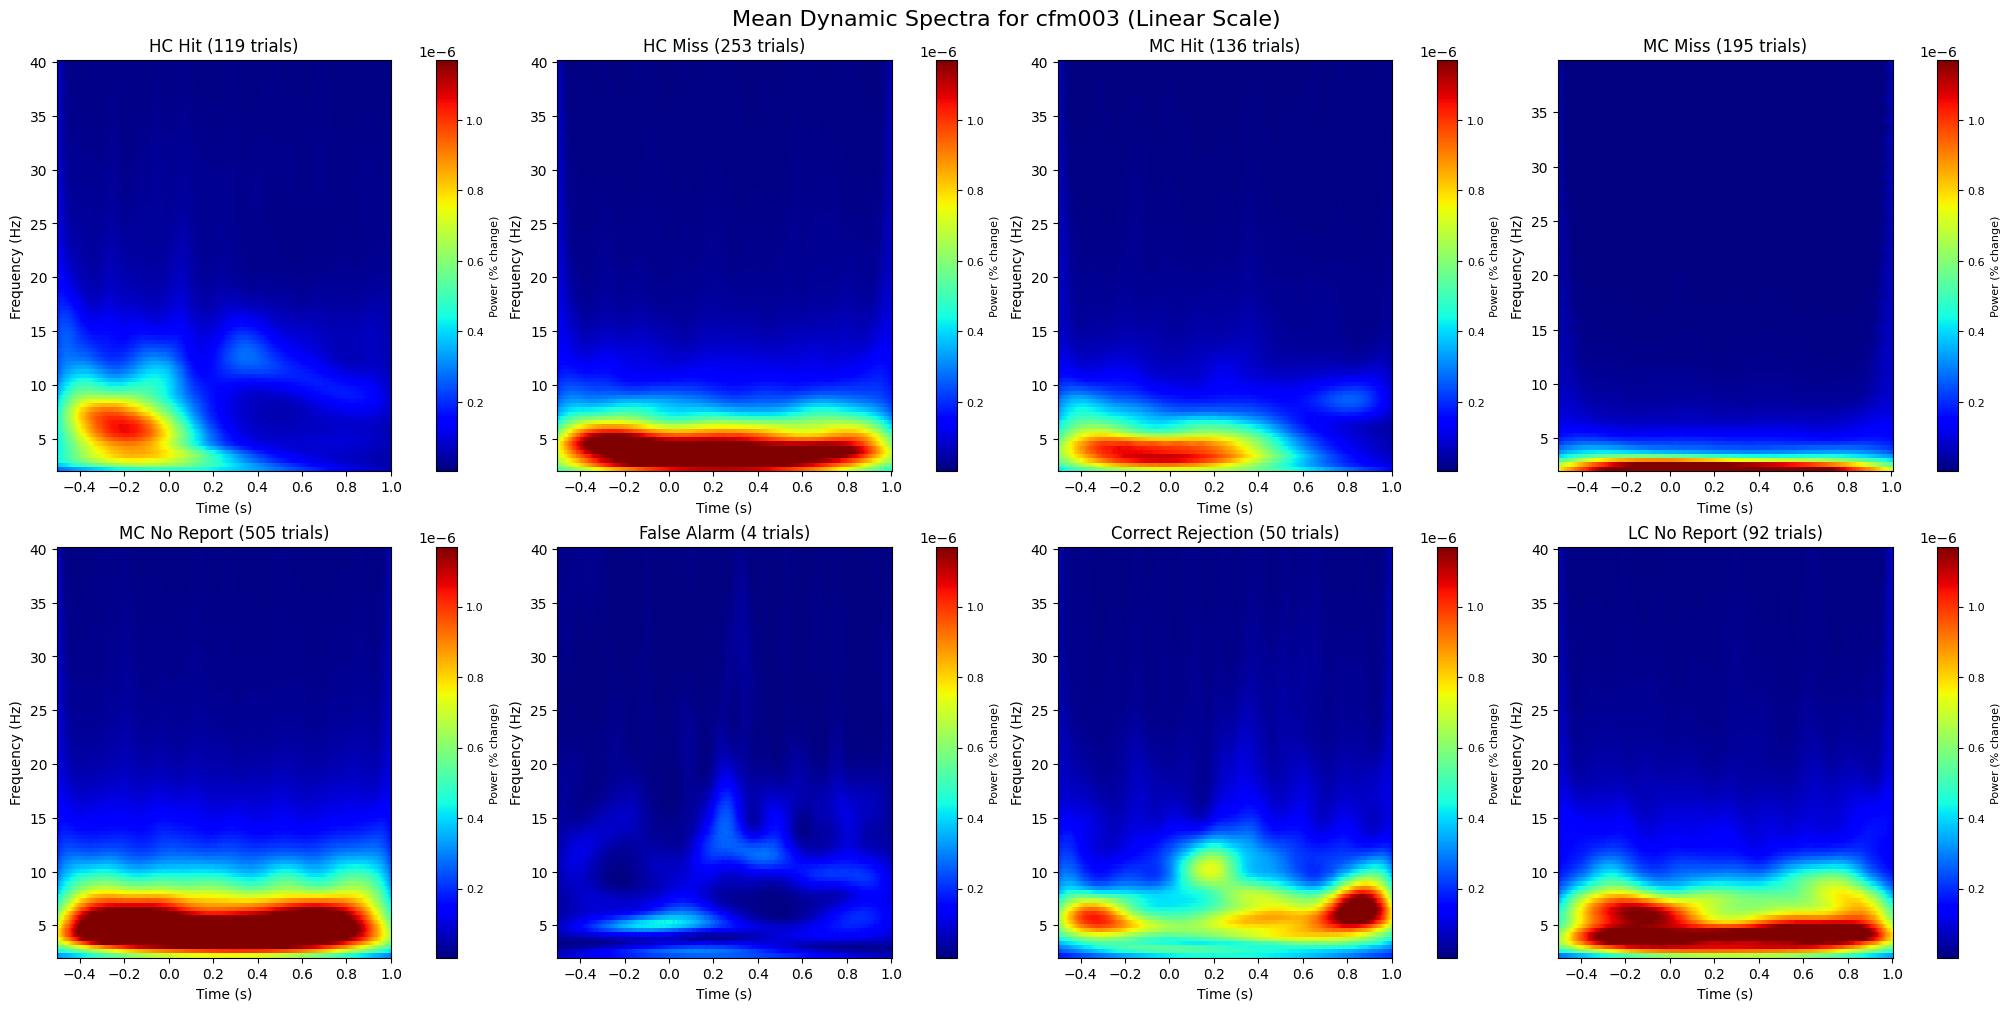

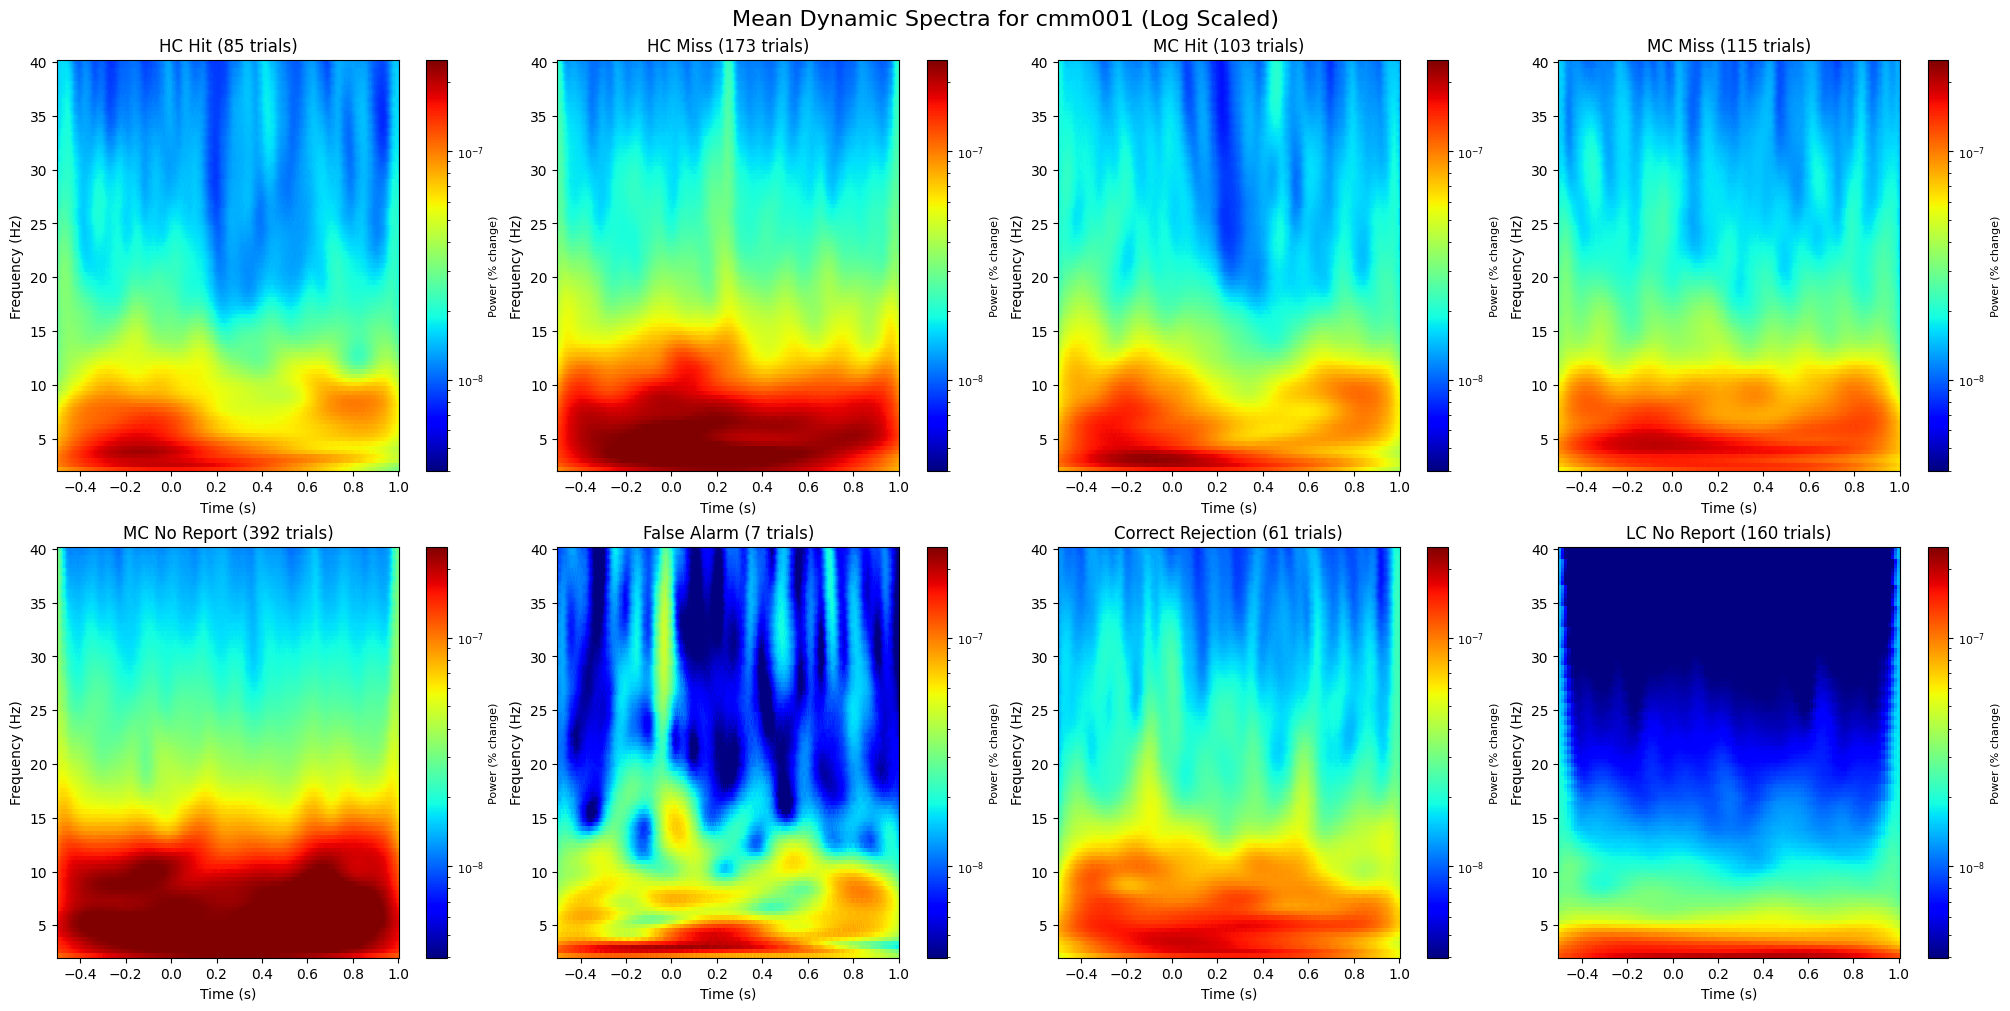

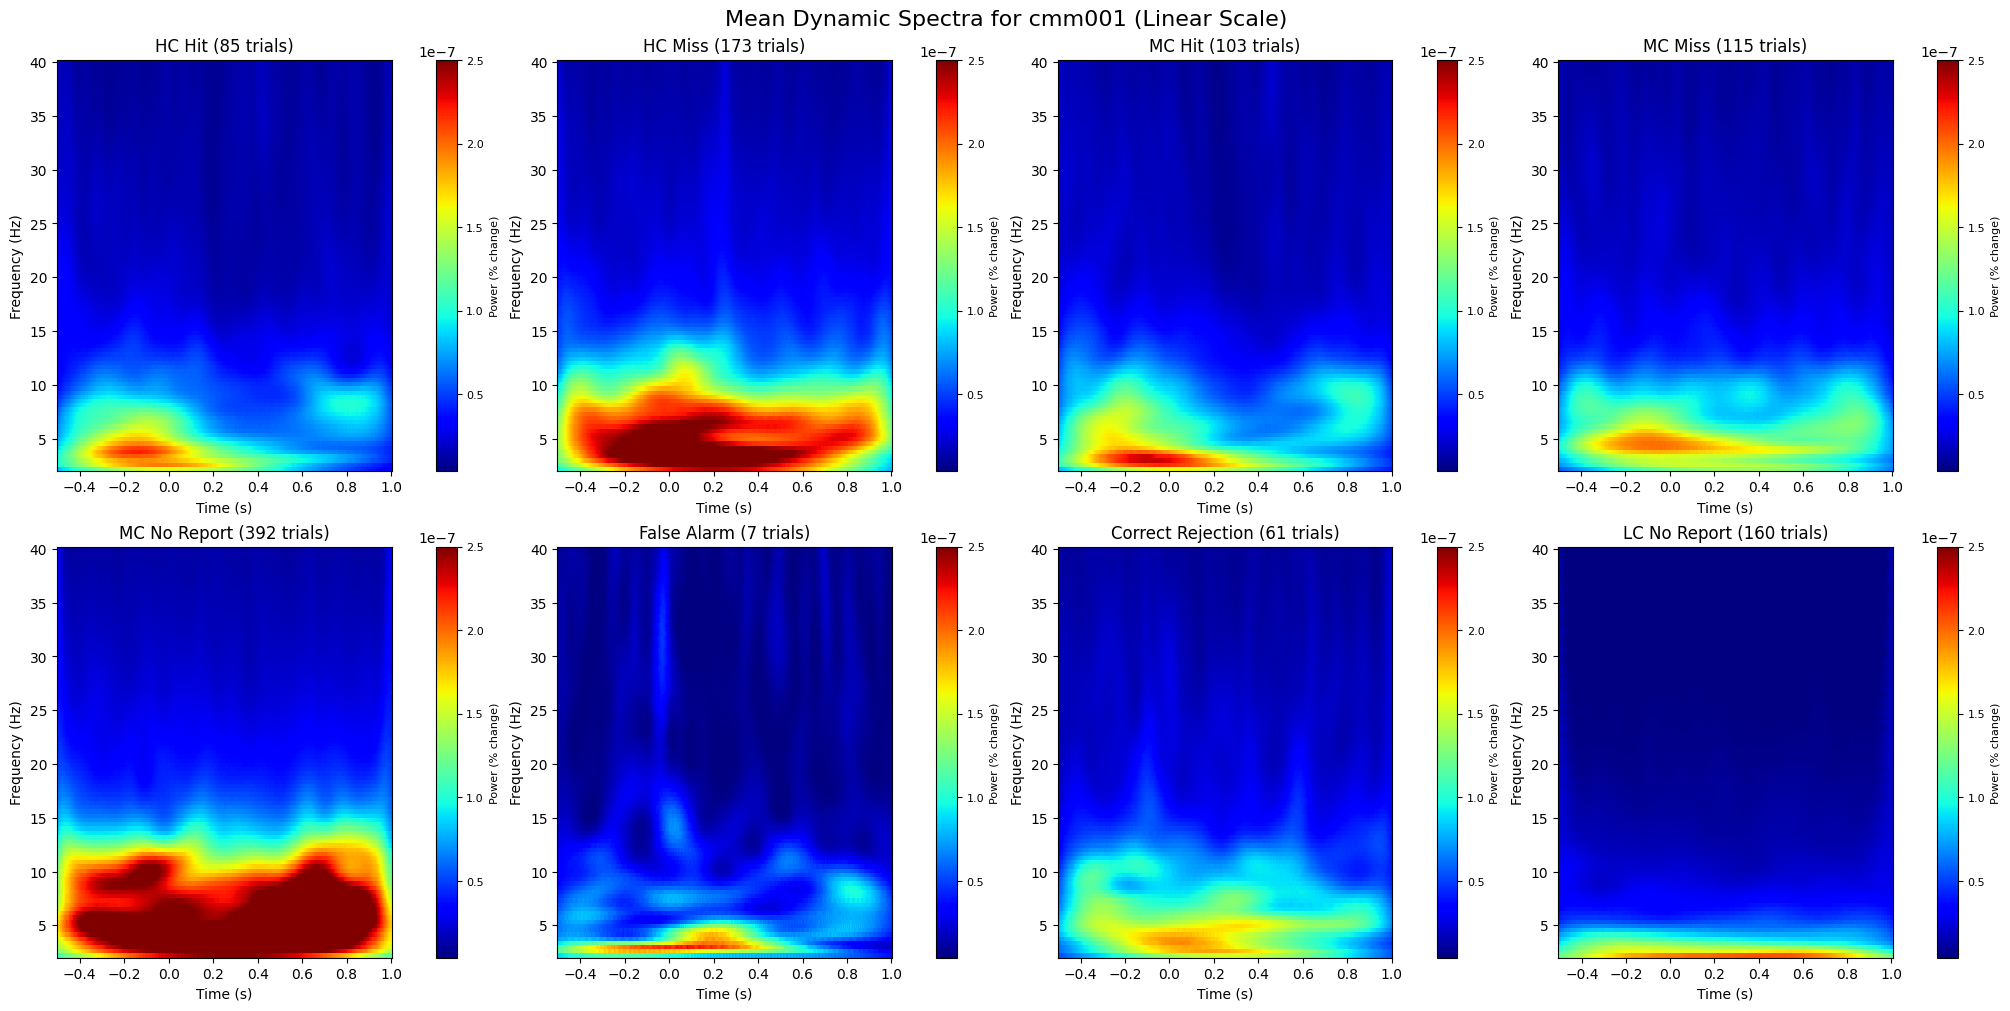

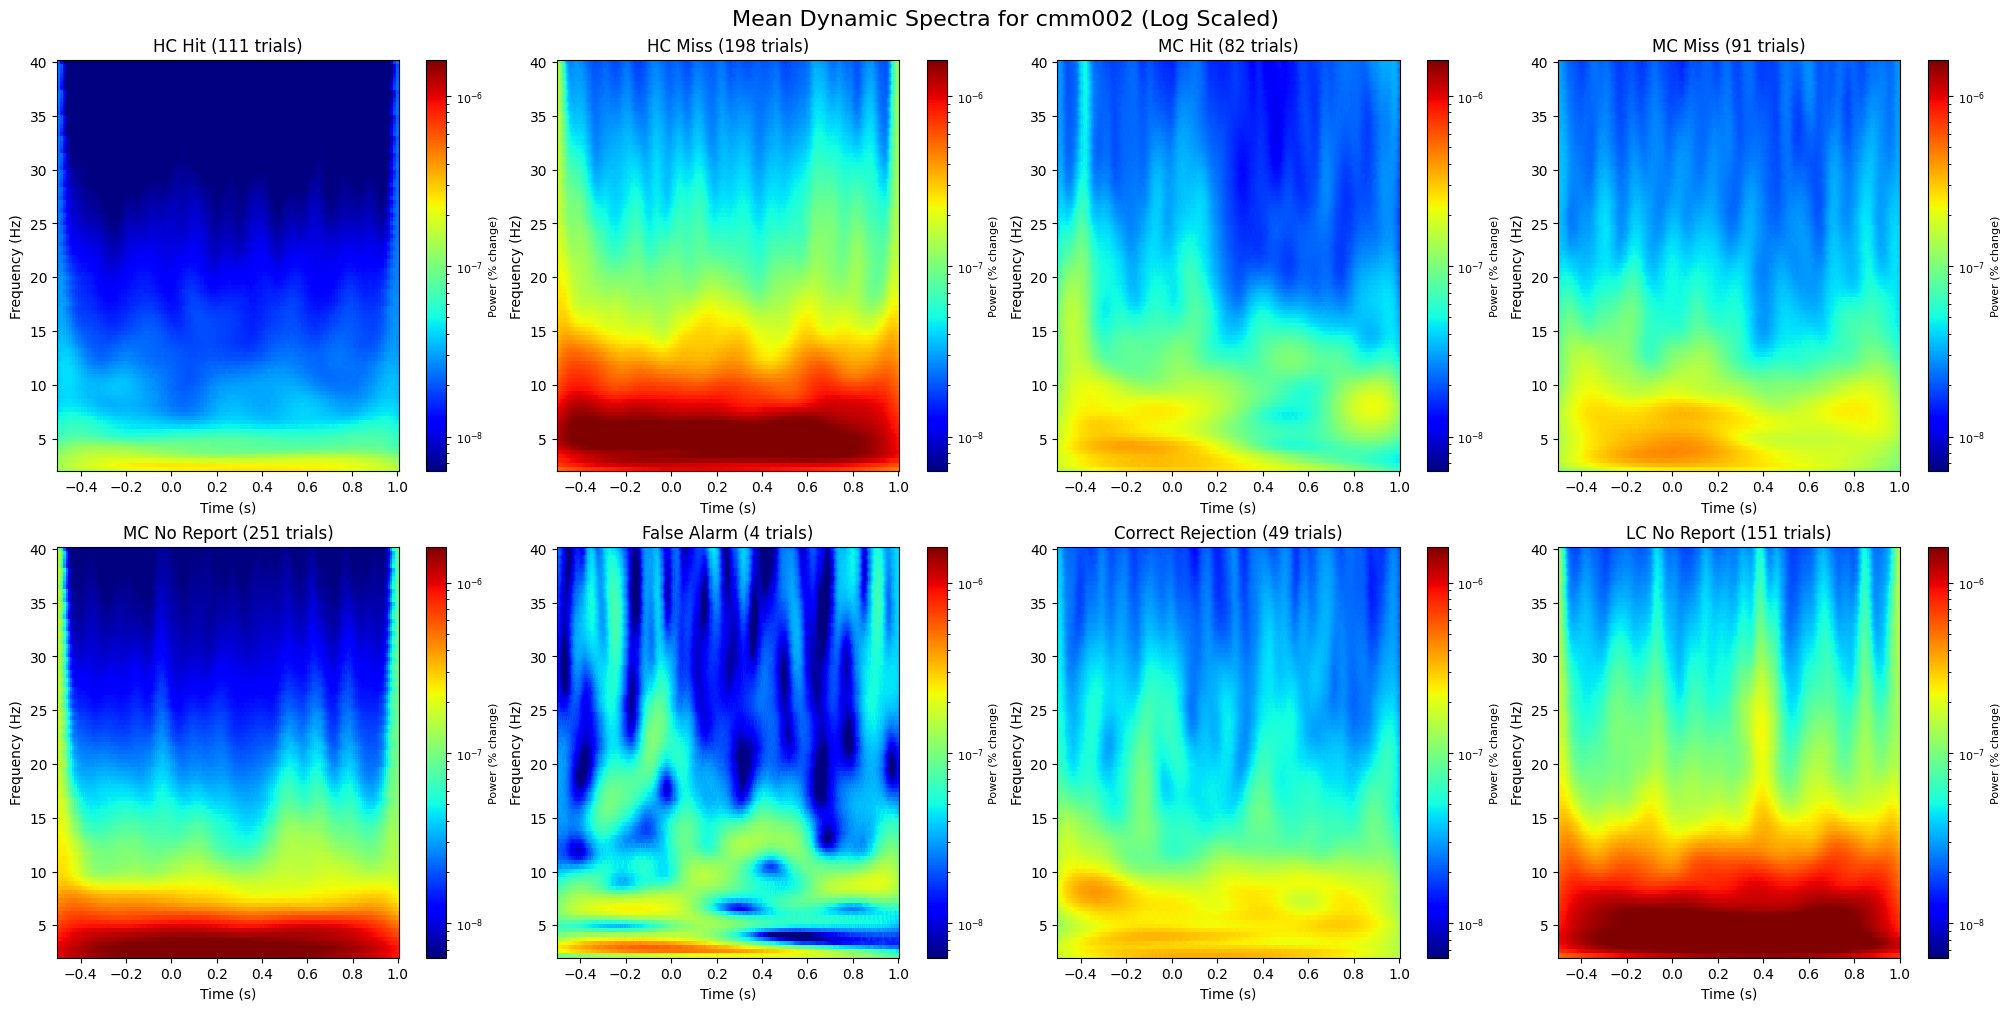

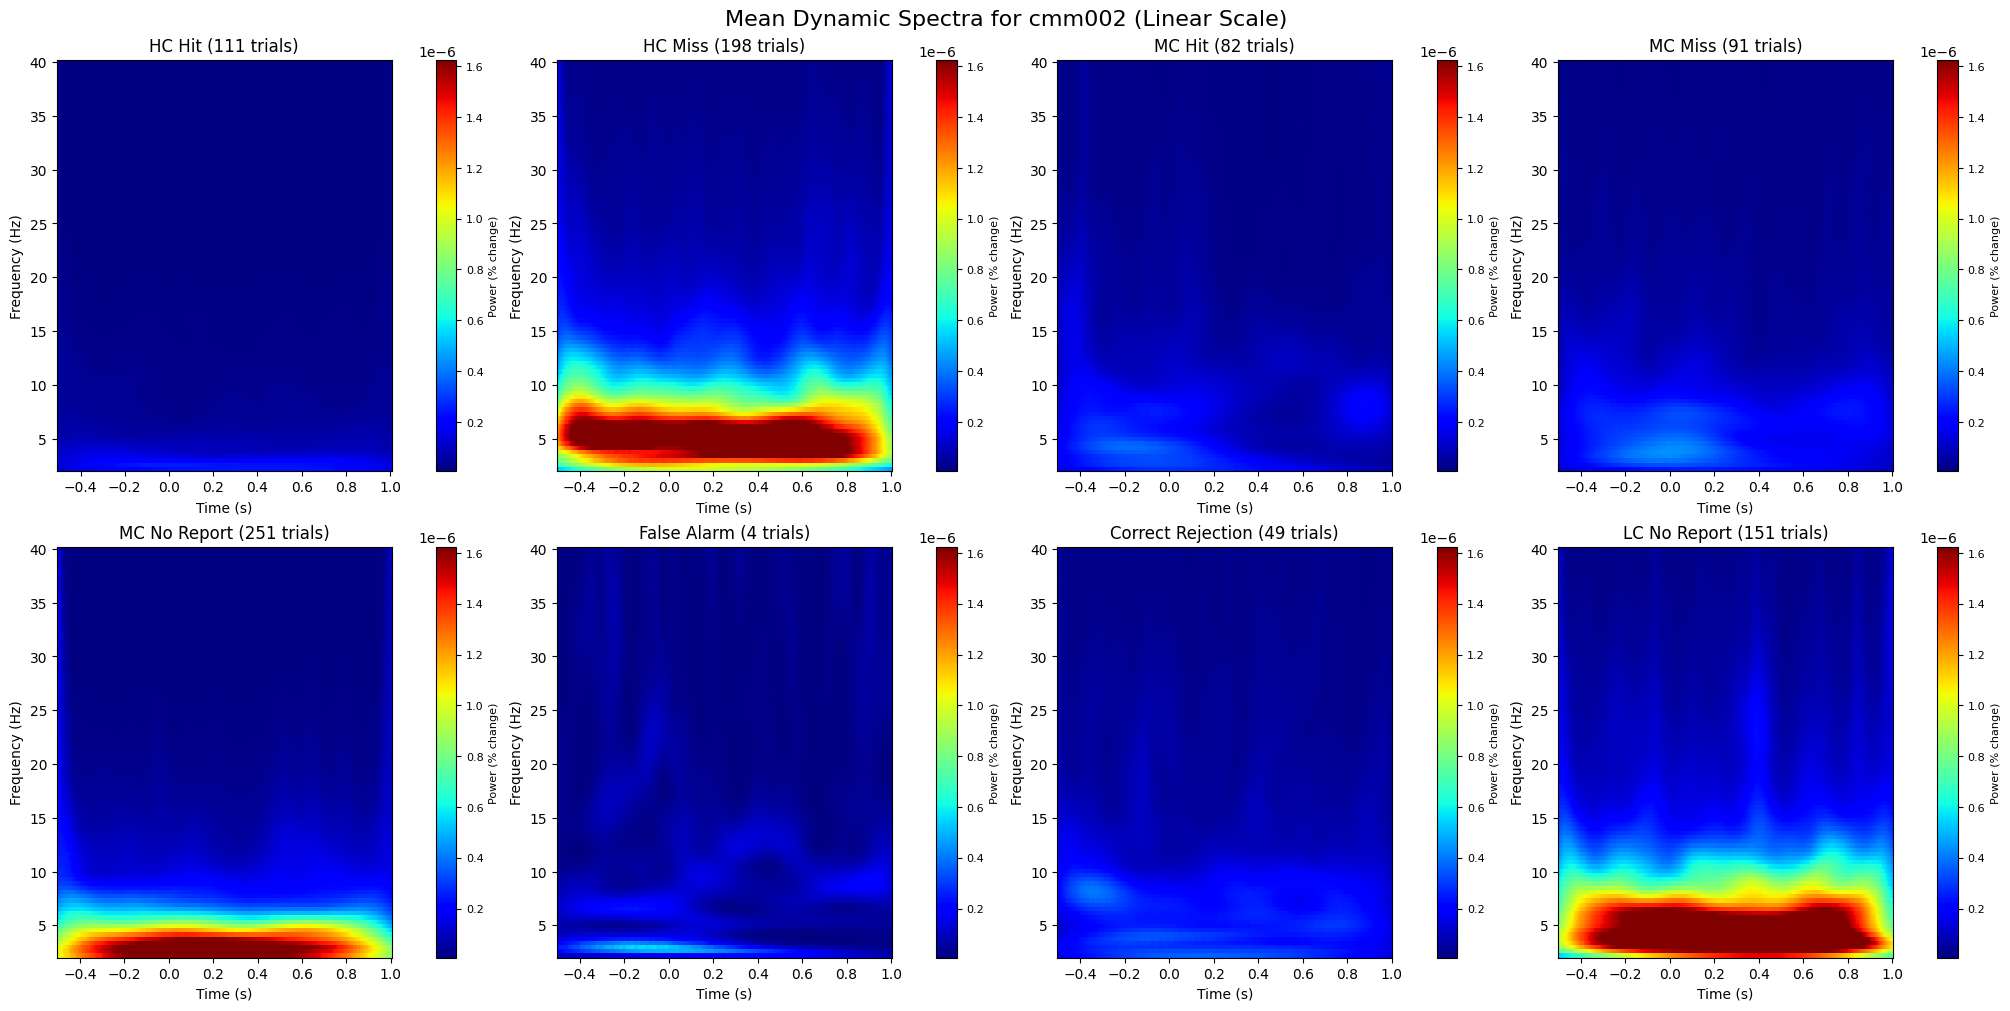

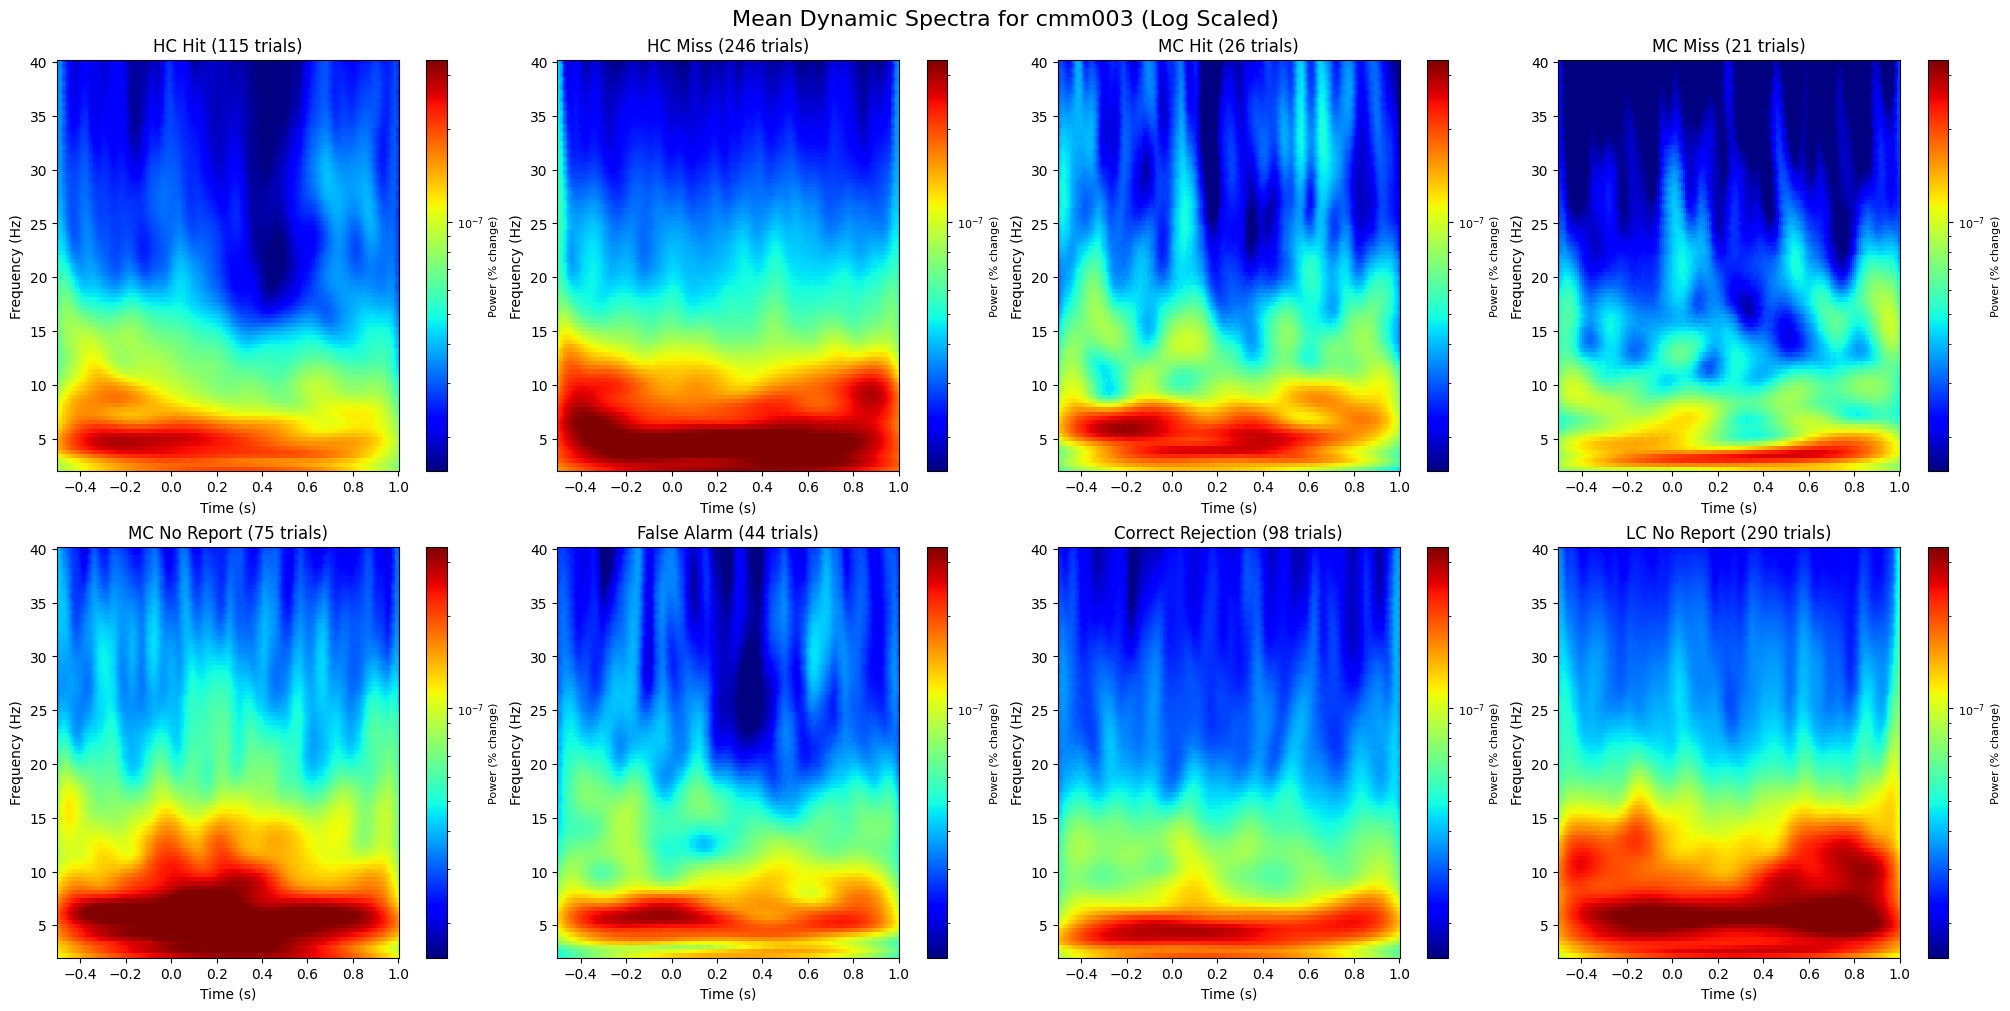

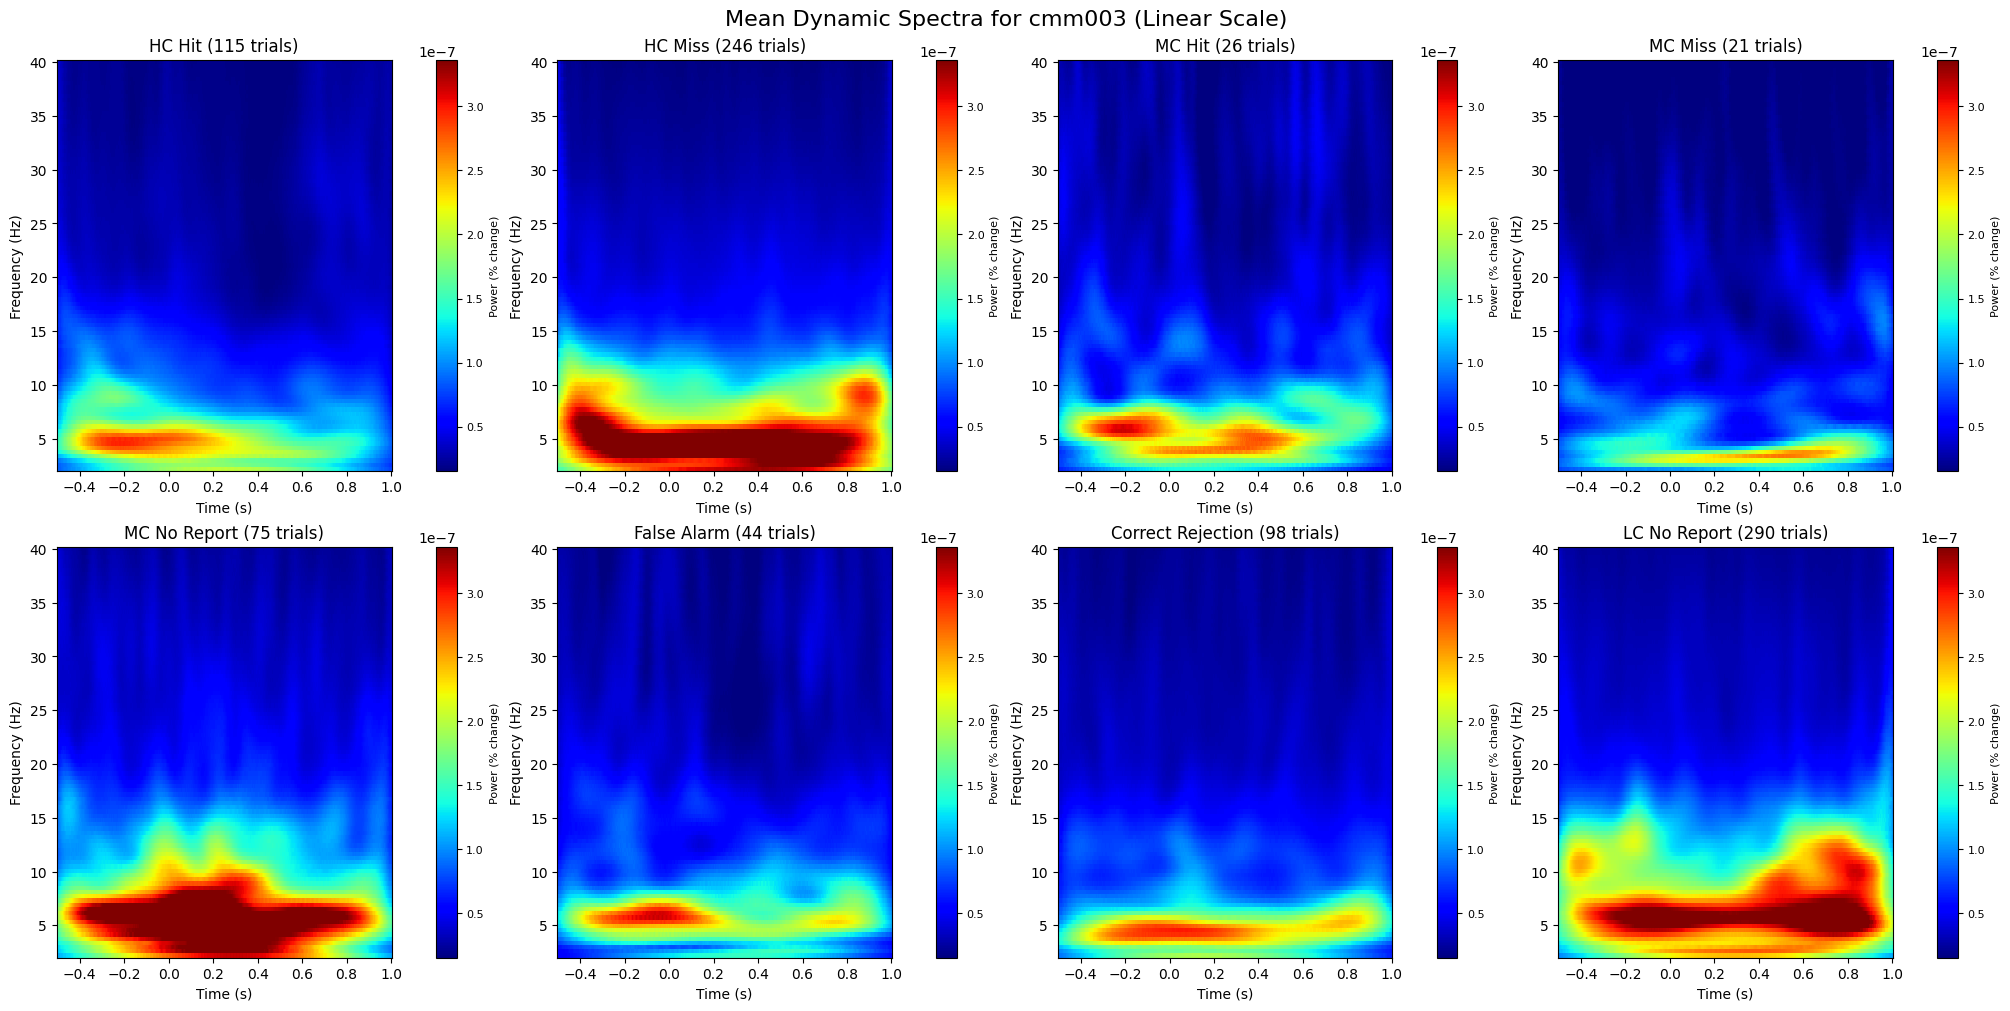

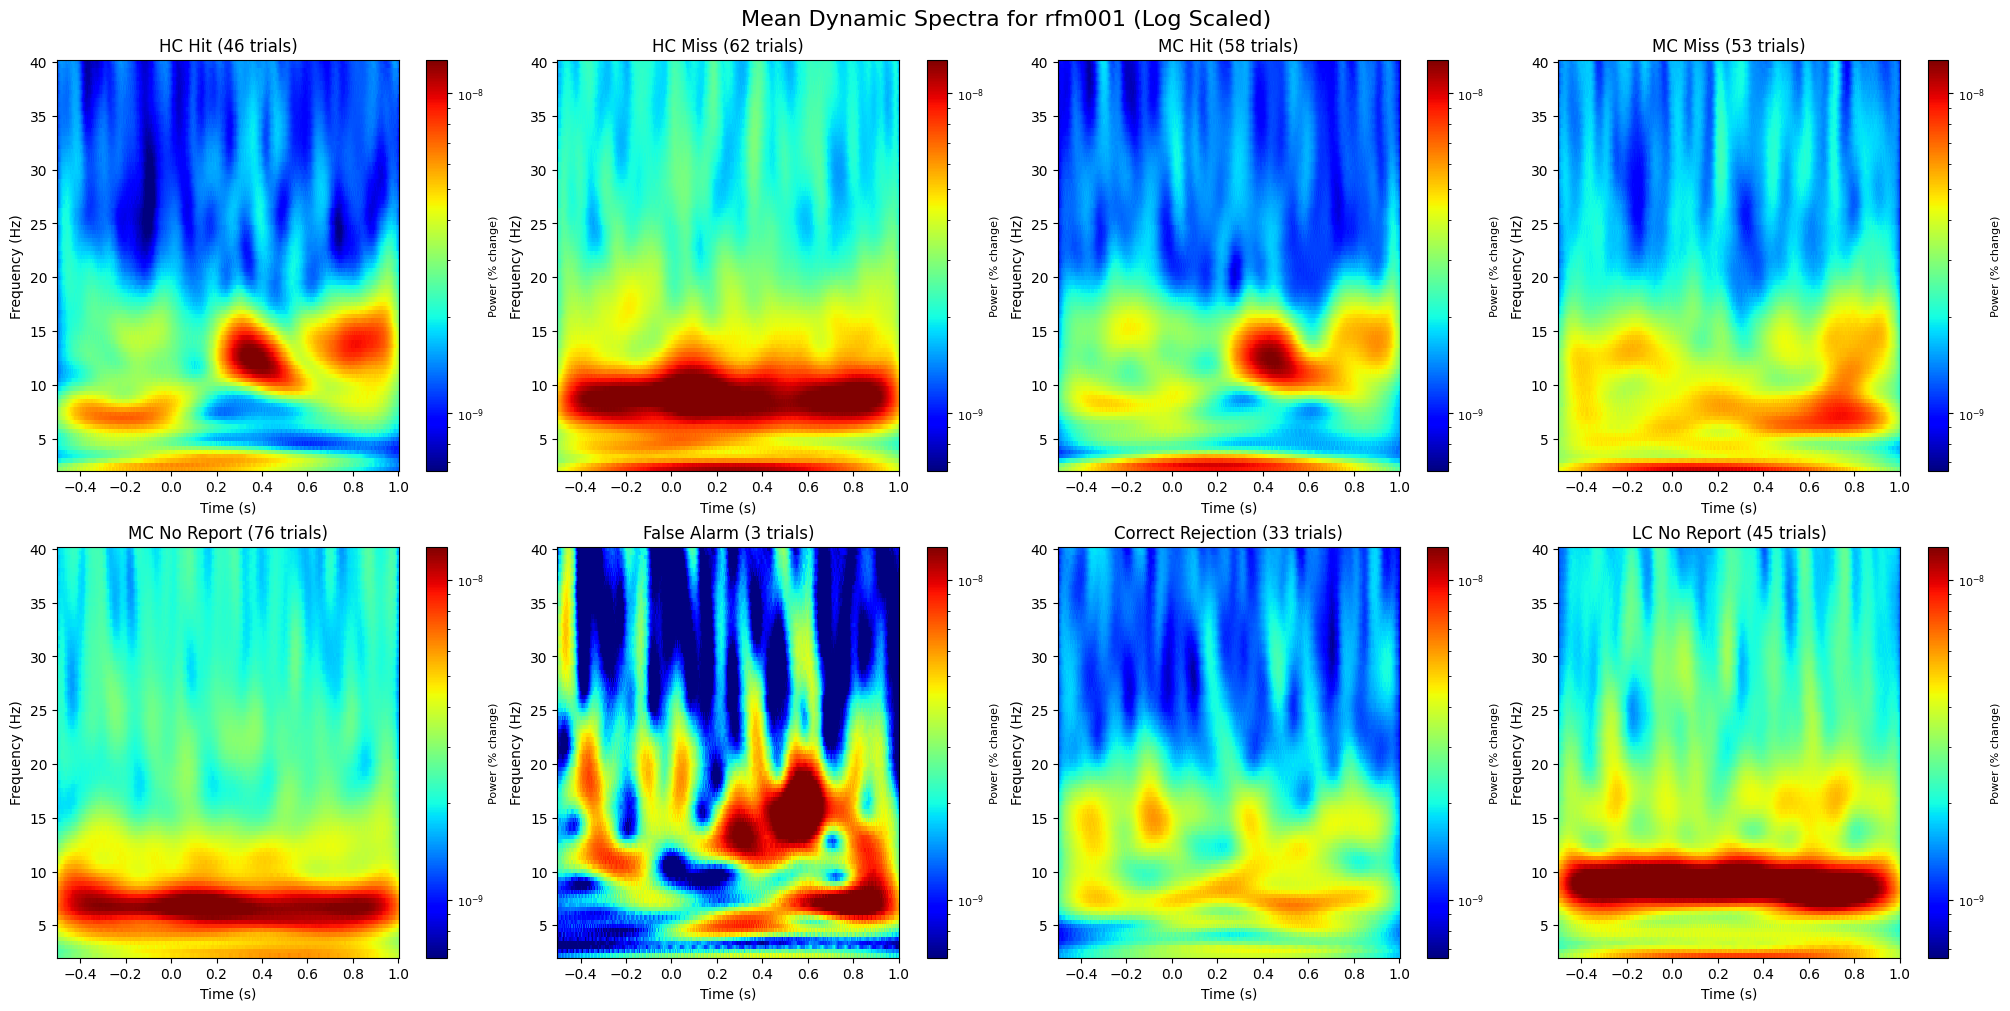

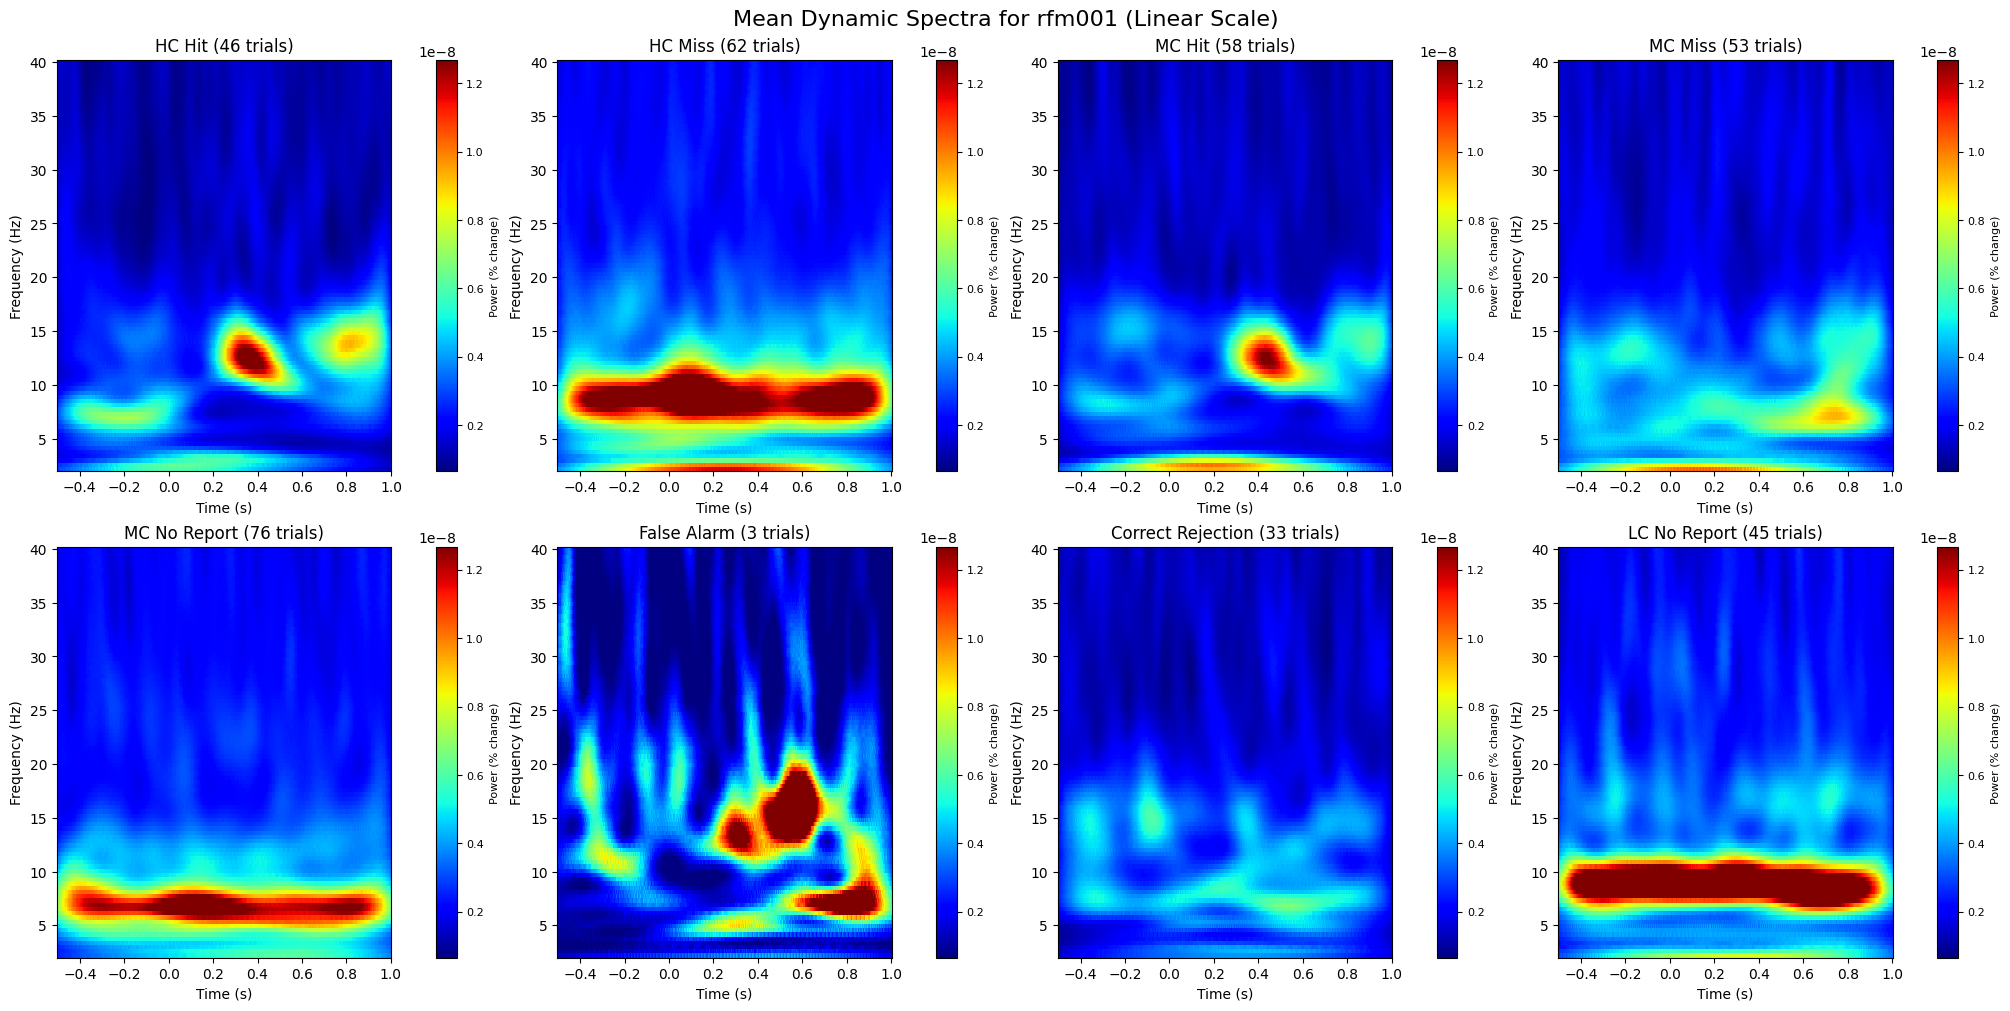

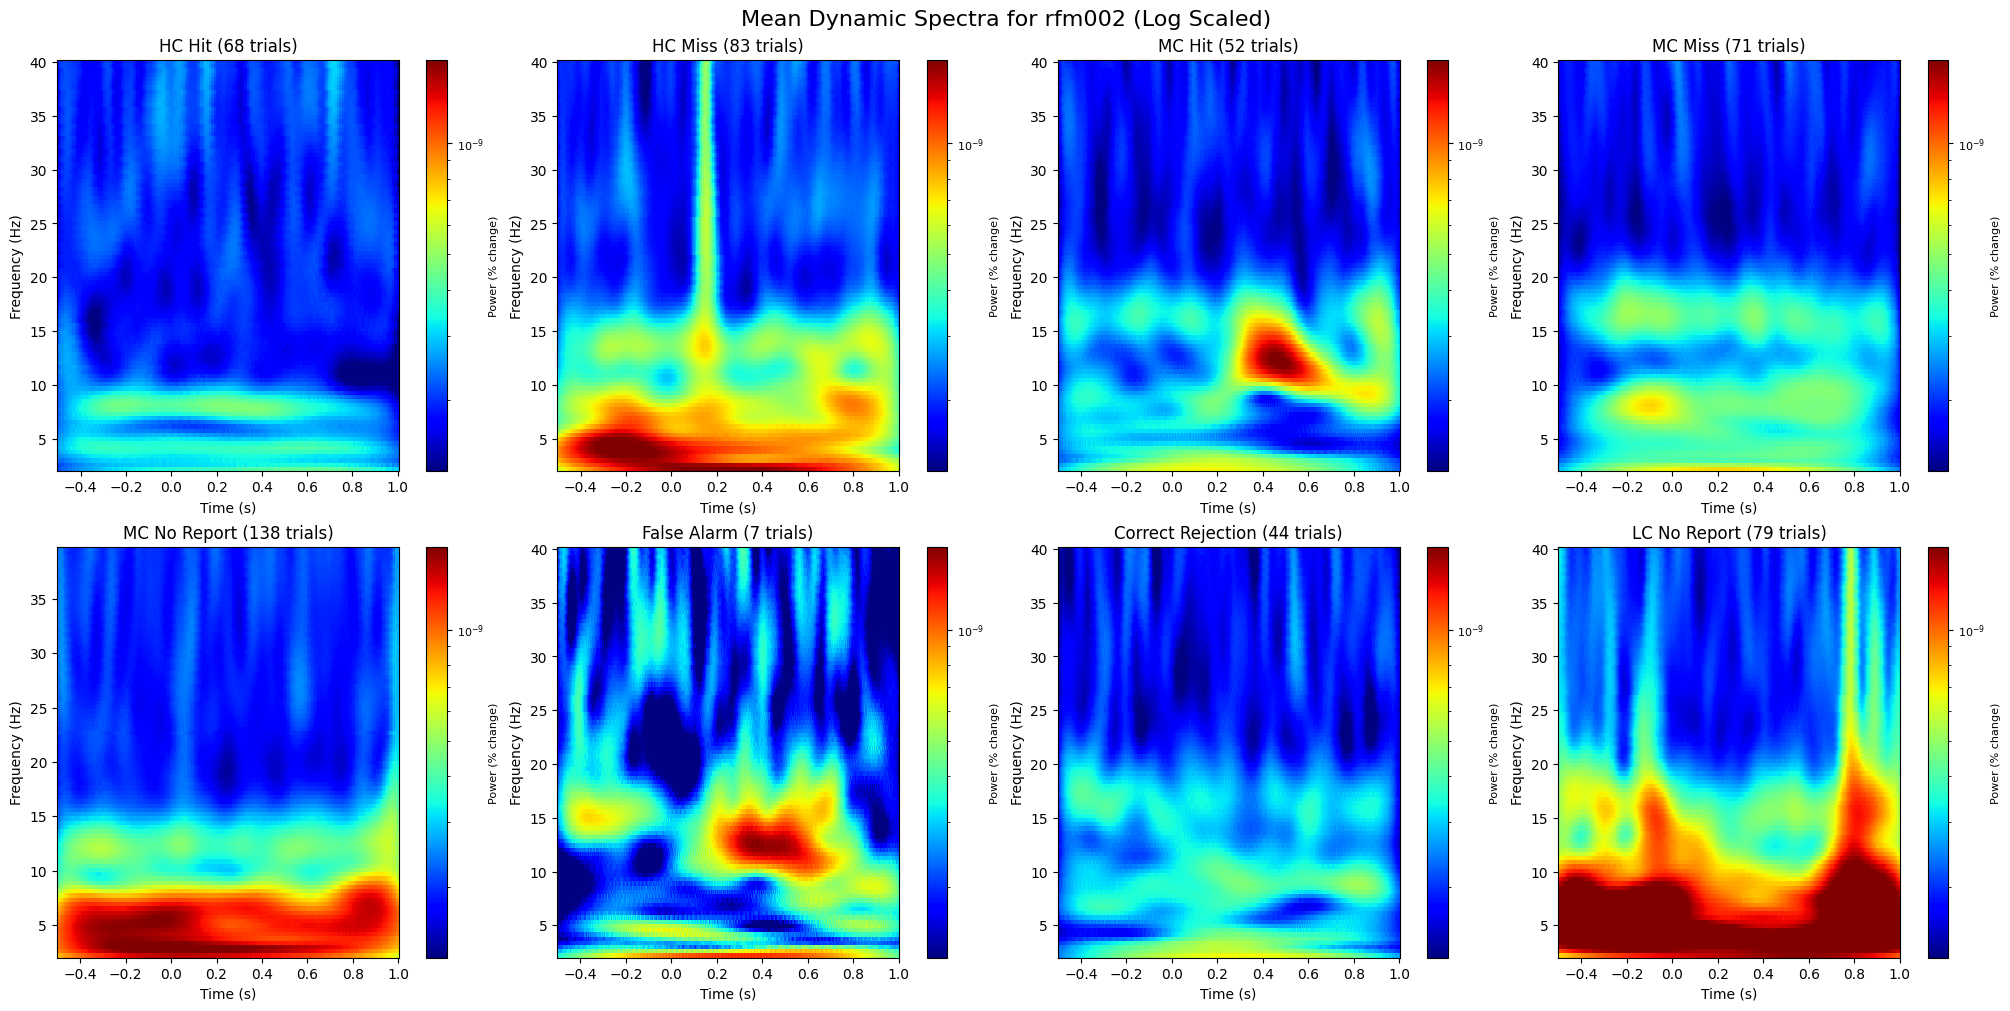

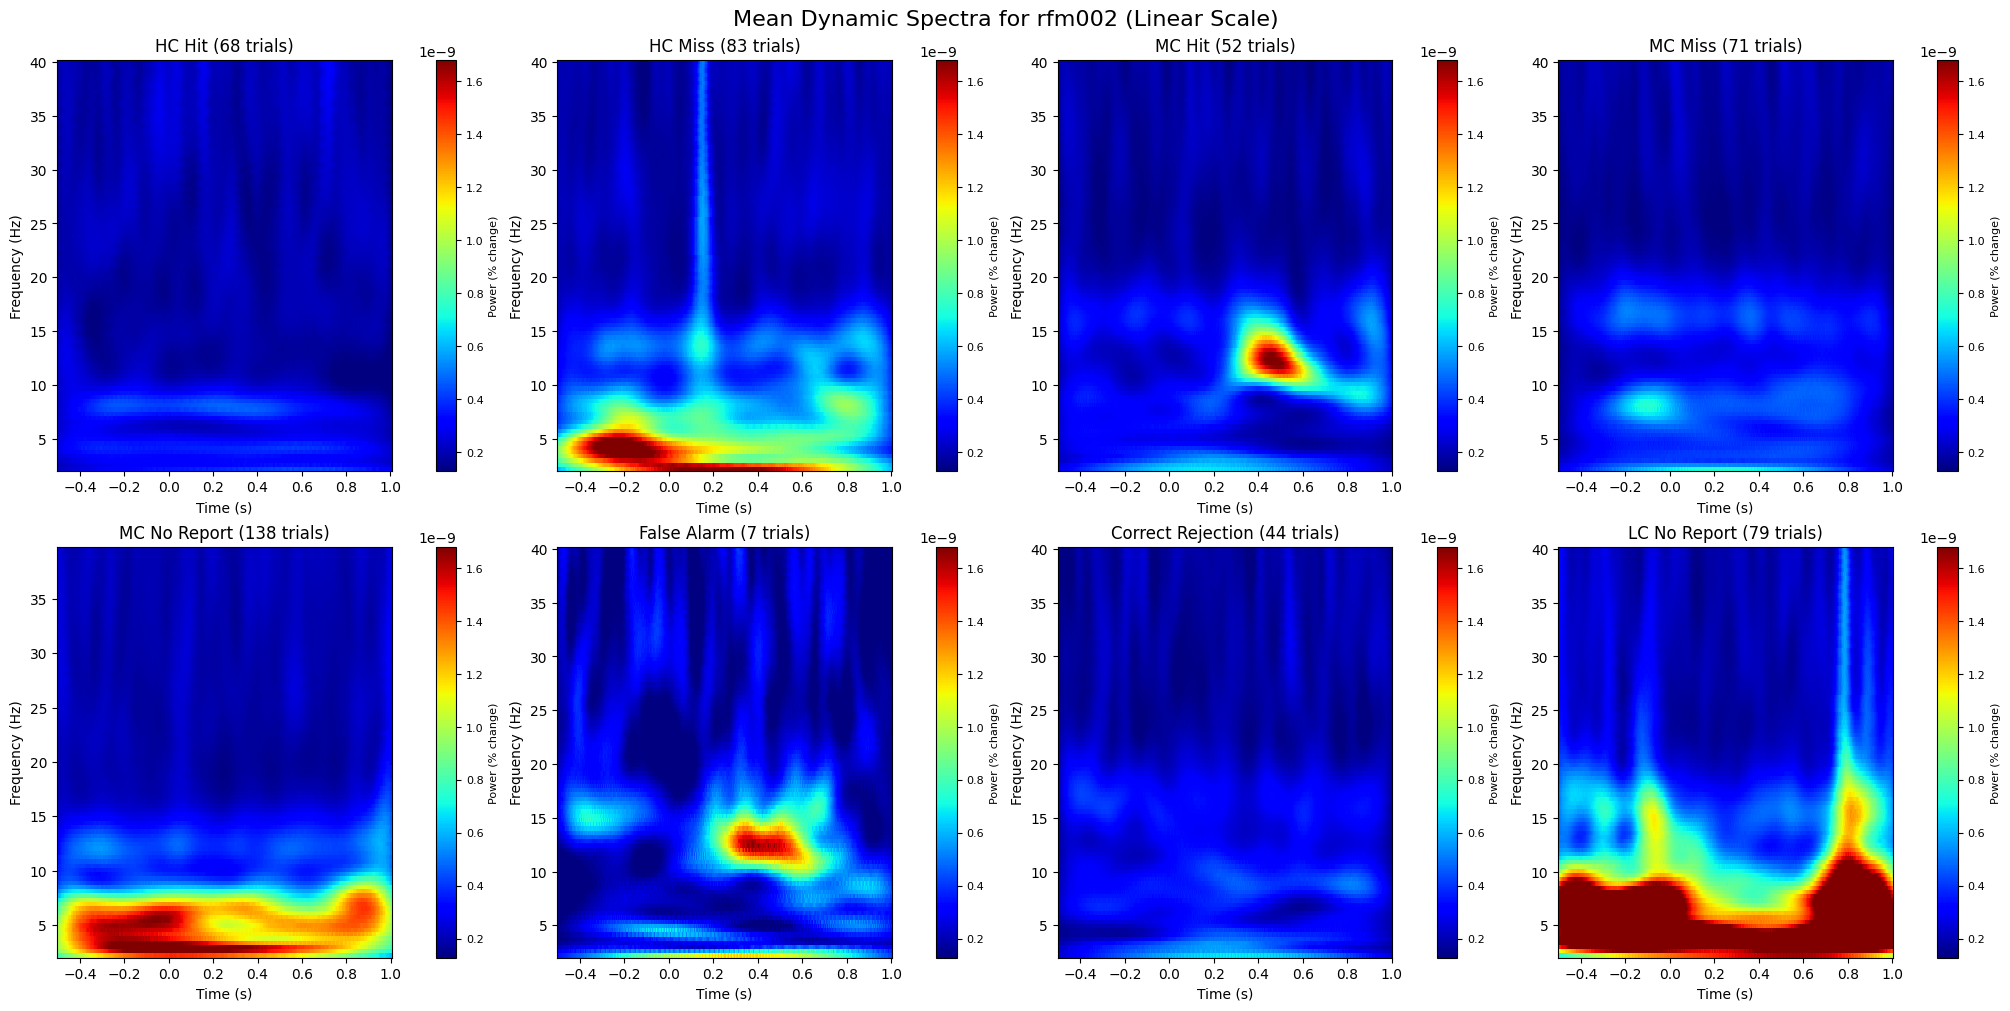

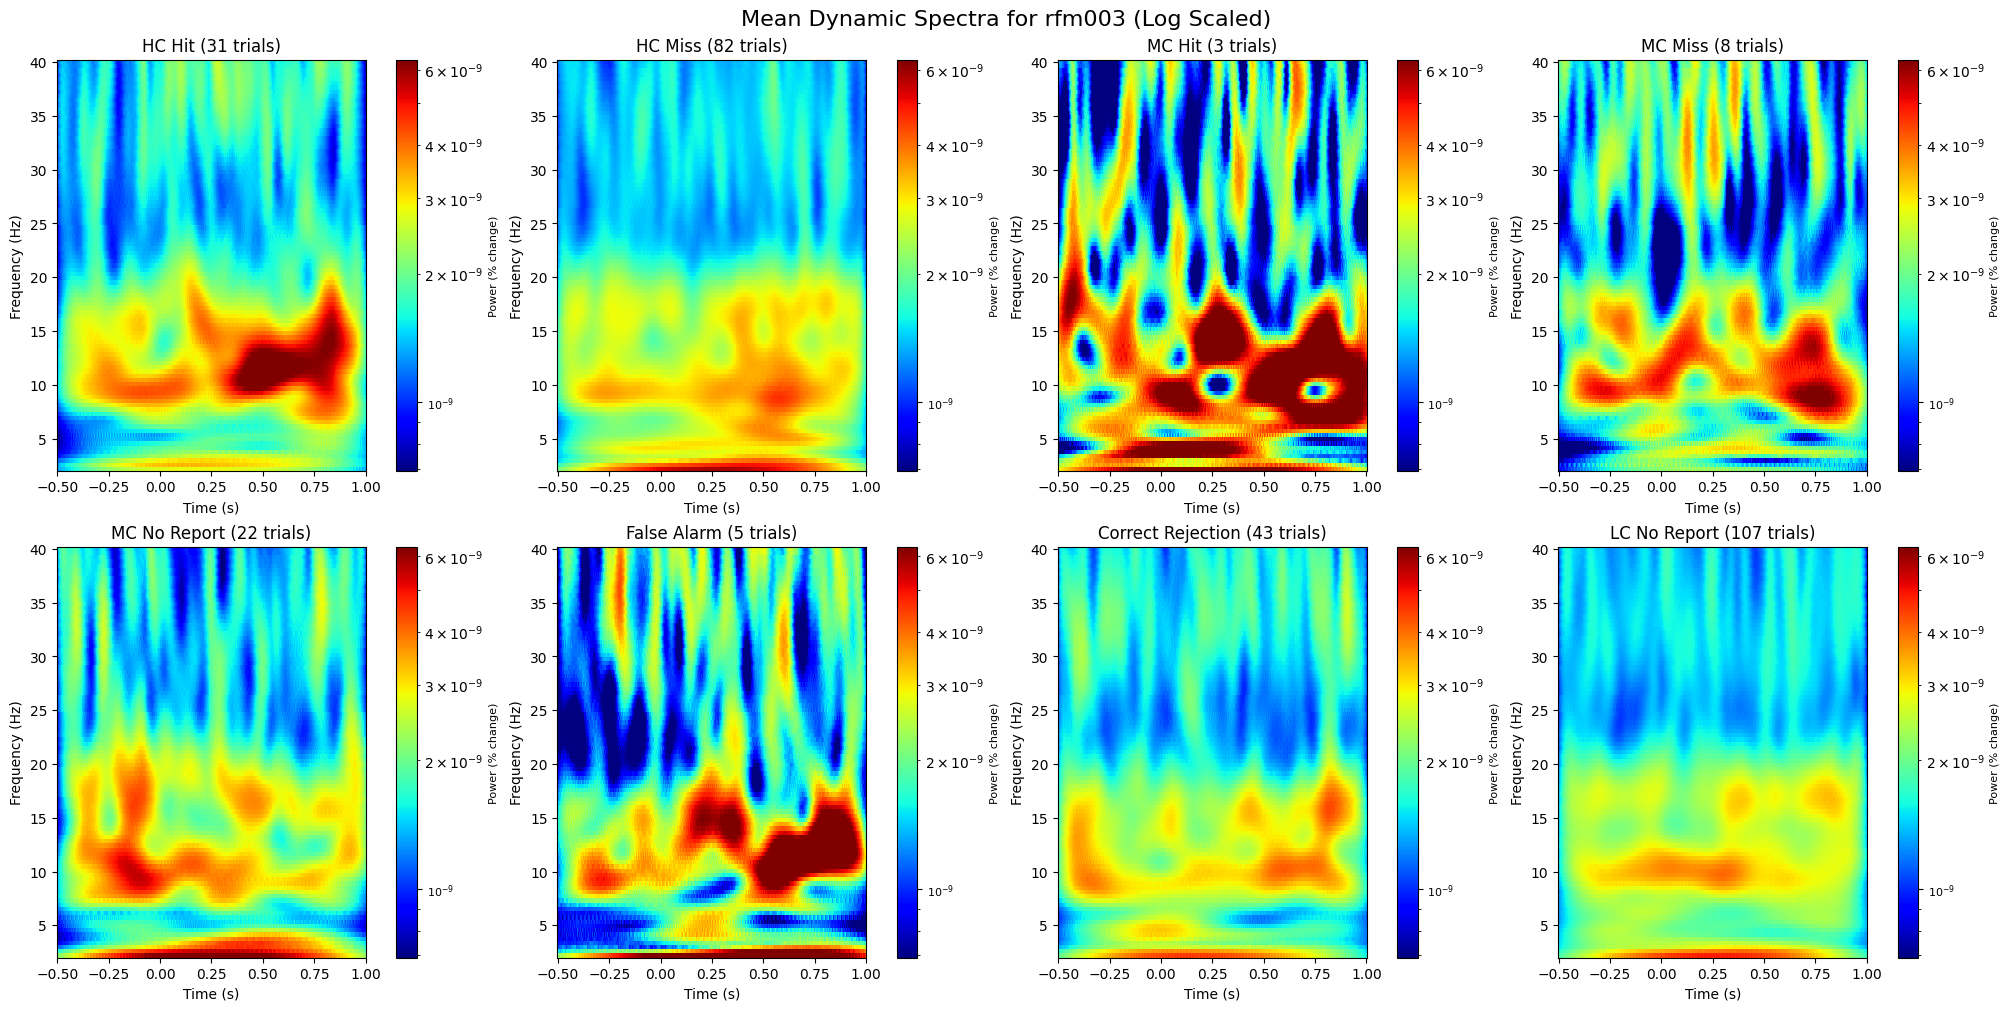

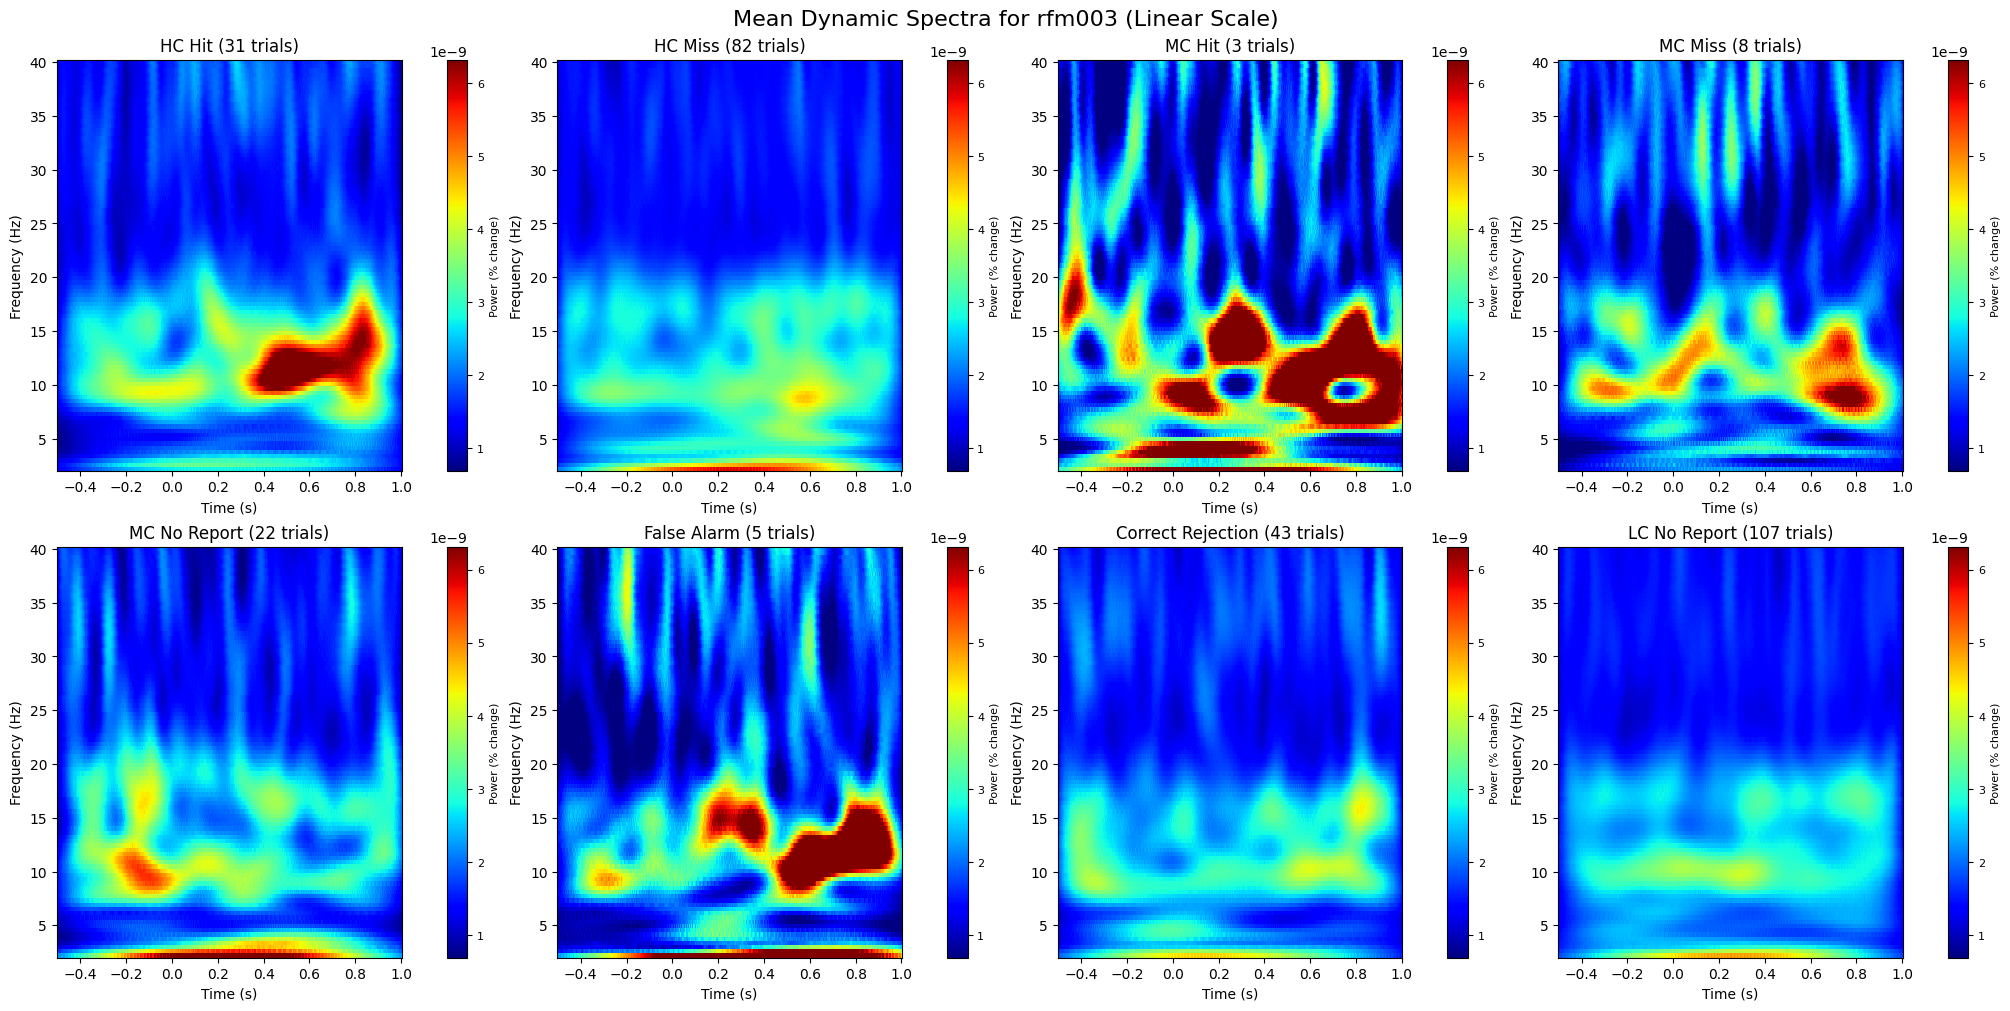

In [51]:
for mouse_name in mouse_names:
    plot_mouse_mean_spectra(mouse_name, all_results, logscale=True)
    plot_mouse_mean_spectra(mouse_name, all_results)